## Zdroj dat

Budeme se zabývat predikcí délky dožití v různých zemích a letech.
K dispozici máme trénovací data v souboru `data.csv`. Udaje byly převzaty z https://www.kaggle.com/datasets/kumarajarshi/life-expectancy-who

### Seznam příznaků:

* Year - Rok
* Status - Status rozvinuté nebo rozvojové země
* Life expectancy - Délka dožití v letech - **cílová proměnná, kterou budeme predikovat**
* Adult Mortality - Úmrtnost dospělých bez ohledu na pohlaví (pravděpodobnost, že osoby, které dosáhly věku 15 let, zemřou před dosažením věku 60 let (uvedeno na 1 000 osob)).
* infant deaths - počet zemřelých kojenců na 1000 obyvatel
* Alcohol - Alkohol, zaznamenaná spotřeba na obyvatele (15+) (v litrech čistého alkoholu)
* percentage expenditure - Výdaje na zdravotnictví v procentech hrubého domácího produktu na obyvatele (%)
* Hepatitis B - pokrytí očkováním proti hepatitidě B (HepB) u dětí ve věku 1 roku (%)
* Measles - Spalničky - počet hlášených případů na 1000 obyvatel
* BMI - průměrný index tělesné hmotnosti celé populace
* under-five deaths - počet úmrtí dětí do pěti let na 1000 obyvatel
* Polio - proočkovanost proti dětské obrně (Pol3) u dětí ve věku 1 roku (%)
* Total expenditure - Výdaje vládních institucí na zdravotnictví jako procento celkových vládních výdajů (%)
* Diphtheria - pokrytí očkováním proti záškrtu, tetanu a černému kašli (DTP3) u jednoletých dětí (%)
* HIV/AIDS - počet úmrtí na 1 000 živě narozených dětí na HIV/AIDS (0-4 roky)
* GDP - hrubý domácí produkt na obyvatele (v USD)
* Population - počet obyvatel země
* thinness 1-19 years - podíl dětí ve věku 10-19 let s indexem tělesné hmotnosti (BMI) menším než 2 směrodatné odchylky pod mediánem (%)
* thinness 5-9 years - podíl dětí ve věku 5-9 let s indexem tělesné hmotnosti (BMI) menším než 2 směrodatné odchylky pod mediánem (%)
* Income composition of resources - Index lidského rozvoje z hlediska příjmového složení zdrojů (index v rozmezí 0 až 1)
* Schooling - počet let školní docházky (roky)


## Obsah projektu

* V notebooku načtěme data ze souboru `data.csv`. Vhodným způsobem si je rozdělme na podmnožiny, které nám poslouží pro trénování (trénovací), porovnávání modelů (validační) a následnou predikci výkonnosti finálního modelu (testovací).
  
* Proveďme základní předzpracování dat:
  * Projděme si jednotlivé příznaky a transformujme je do vhodné podoby pro použití ve vybraném regresním modelu.
  * Nějakým způsobem se vypořádejme s chybějícími hodnotami.
<br /><br />
* Vytvořme **vlastní implementaci náhodného lesa**.

* Na připravená data postupně aplikujme naši předchozí implementaci modelu **náhodného lesa**, dále **hřebenovou regrese**, a **AdaBoost**, přičemž pro každý z těchto modelů:
  * Experimentujme s normalizací (standardizace/min-max)
  * Vyberme si hlavní hyperparametry k ladění a najděme jejich nejlepší hodnoty (vzhledem k RMSE).
  * Pro model s nejlepšími hodnotami hyperparametrů určeme jeho chybu pomocí RMSE a MAE.
<br /><br />
* Ze všech zkoušených možností v předchozím kroku vyberme finální model a odhadněme, jakou chybu (RMSE) můžeme očekávat na nových datech, která jsme doposud neměli k dispozici.

In [57]:
import math

import pandas as pd
import numpy as np
import seaborn as sns
sns.set_theme(palette='dark',style='darkgrid')

from scipy import optimize

import matplotlib.pyplot as plt
%matplotlib inline

random_seed = 110723
import sklearn.metrics as metrics

from sklearn.model_selection import train_test_split
from sklearn.model_selection import ParameterGrid

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import FunctionTransformer, PowerTransformer


# WARNING: use pip install category_encoders if error occurs
from category_encoders import BinaryEncoder

from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import Ridge
from sklearn.ensemble import AdaBoostRegressor

# ignore all future warnings
from warnings import simplefilter
simplefilter(action='ignore', category=FutureWarning)

# Implementaci náhodného lesa

In [58]:
########################################################
class CustomRandomForest:
    """
    Třída našeho modelu
    Jedna se o model náhodného lesa, kde podmodely tvoří rozhodovací stromy pro regresi.
    Pro podmodely můžeme použít implementaci DecisionTreeRegressor ze sklearn.
    """
    def __init__(self, n_estimators, max_samples, max_depth, **kwargs):
        """
        Konstruktor modelu
        Základní hyperparametery:
            n_estimators - počet podmodelů - rozhodovacích stromů.
            max_samples - tento parametr bude označovat absolutní počet bodů (tj. číslo mezi 1 a velikostí trénovací množiny), 
                          které budou pro každý podmodel rozhodovacího stromu náhodně vybrány z trénovací množiny (bootstrap)
                          a použity k jeho trénování.
            max_depth - maximální hloubka každého z podmodelů rozhodovacího stromu.
            kwargs - (volitelně) případné další hyperparametry, které pošleme do podmodelů rozhodovacího stromu
        """
        # Max_samples is absolute number of points
        self.n_estimators = n_estimators
        self.max_samples = max_samples
        self.max_depth = max_depth
        self.kwargs = kwargs
        self.trees = []
        
    def fit(self, X, y):
        """
        Natrénování modelu. Trénovací data jsou v argumentech X a y.
        Pro trénování podmodelů používejme bootstraping
        """
        num_samples = X.shape[0]

        for _ in range(self.n_estimators):
            # Bootstrap sampling
            indices = np.random.choice(num_samples, self.max_samples, replace=True)
            X_bootstrap = X.iloc[indices]
            y_bootstrap = y.iloc[indices]
            # Create and train a decision tree
            tree = DecisionTreeRegressor(max_depth=self.max_depth, **self.kwargs)
            tree.fit(X_bootstrap, y_bootstrap)
            self.trees.append(tree)
        
    def predict(self, X):
        """
        Predikce y v zadaných bodech X
        """
        y_predicted = np.zeros((X.shape[0],))

        for tree in self.trees:
            y_predicted += tree.predict(X)

        return y_predicted / self.n_estimators

# Načteni dat

In [59]:
df = pd.read_csv("data.csv")
df

,Country,Year,Status,Life expectancy,Adult Mortality,infant deaths,Alcohol,percentage expenditure,Hepatitis B,Measles,...,Polio,Total expenditure,Diphtheria,HIV/AIDS,GDP,Population,thinness 1-19 years,thinness 5-9 years,Income composition of resources,Schooling
0,Afghanistan,2015,Developing,65.0,263.0,62,0.01,71.279624,65.0,1154,...,6.0,8.16,65.0,0.1,584.259210,33736494.0,17.2,17.3,0.479,10.1
1,Afghanistan,2014,Developing,59.9,271.0,64,0.01,73.523582,62.0,492,...,58.0,8.18,62.0,0.1,612.696514,327582.0,17.5,17.5,0.476,10.0
2,Afghanistan,2013,Developing,59.9,268.0,66,0.01,73.219243,64.0,430,...,62.0,8.13,64.0,0.1,631.744976,31731688.0,17.7,17.7,0.470,9.9
3,Afghanistan,2012,Developing,59.5,272.0,69,0.01,78.184215,67.0,2787,...,67.0,8.52,67.0,0.1,669.959000,3696958.0,17.9,18.0,0.463,9.8
4,Afghanistan,2011,Developing,59.2,275.0,71,0.01,7.097109,68.0,3013,...,68.0,7.87,68.0,0.1,63.537231,2978599.0,18.2,18.2,0.454,9.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2713,Zimbabwe,2004,Developing,44.3,723.0,27,4.36,0.000000,68.0,31,...,67.0,7.13,65.0,33.6,454.366654,12777511.0,9.4,9.4,0.407,9.2
2714,Zimbabwe,2003,Developing,44.5,715.0,26,4.06,0.000000,7.0,998,...,7.0,6.52,68.0,36.7,453.351155,12633897.0,9.8,9.9,0.418,9.5
2715,Zimbabwe,2002,Developing,44.8,73.0,25,4.43,0.000000,73.0,304,...,73.0,6.53,71.0,39.8,57.348340,125525.0,1.2,1.3,0.427,10.0
2716,Zimbabwe,2001,Developing,45.3,686.0,25,1.72,0.000000,76.0,529,...,76.0,6.16,75.0,42.1,548.587312,12366165.0,1.6,1.7,0.427,9.8


In [60]:
df.describe()

,Year,Life expectancy,Adult Mortality,infant deaths,Alcohol,percentage expenditure,Hepatitis B,Measles,BMI,under-five deaths,Polio,Total expenditure,Diphtheria,HIV/AIDS,GDP,Population,thinness 1-19 years,thinness 5-9 years,Income composition of resources,Schooling
count,2718.000000,2718.000000,2718.000000,2718.000000,2564.000000,2718.000000,2188.000000,2718.000000,2692.000000,2718.000000,2700.000000,2529.000000,2700.000000,2718.000000,2317.000000,2.116000e+03,2692.000000,2692.000000,2576.000000,2576.000000
mean,2007.113687,69.204525,164.432303,30.825239,4.672512,757.071658,80.884826,2370.999632,38.314339,42.767476,82.528148,5.943606,82.135926,1.788263,7646.459541,1.261063e+07,4.892236,4.925149,0.626697,11.996079
std,4.537979,9.612530,125.512789,121.786599,4.051664,2007.472092,25.010075,11174.241799,19.954800,165.704415,23.294376,2.488801,23.849574,5.221587,14455.594394,6.238395e+07,4.434584,4.522269,0.213323,3.364109
min,2000.000000,36.300000,1.000000,0.000000,0.010000,0.000000,1.000000,0.000000,1.000000,0.000000,3.000000,0.370000,2.000000,0.100000,1.681350,3.400000e+01,0.100000,0.100000,0.000000,0.000000
25%,2003.000000,63.100000,73.250000,0.000000,0.990000,5.832385,77.000000,0.000000,19.200000,0.000000,77.000000,4.260000,78.000000,0.100000,459.291200,1.829220e+05,1.600000,1.600000,0.492000,10.100000
50%,2007.000000,72.200000,142.000000,3.000000,3.820000,67.687008,92.000000,18.000000,43.450000,4.000000,93.000000,5.730000,93.000000,0.100000,1741.142552,1.365022e+06,3.400000,3.400000,0.679000,12.300000
75%,2011.000000,75.800000,227.000000,22.000000,7.832500,446.887709,97.000000,372.000000,56.100000,28.000000,97.000000,7.530000,97.000000,0.800000,6337.882993,7.383590e+06,7.200000,7.300000,0.781000,14.300000
max,2015.000000,89.000000,723.000000,1800.000000,17.870000,19479.911610,99.000000,212183.000000,77.600000,2500.000000,99.000000,17.600000,99.000000,50.600000,119172.741800,1.293859e+09,27.700000,28.600000,0.938000,20.700000


In [61]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2718 entries, 0 to 2717
Data columns (total 22 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   Country                          2718 non-null   object 
 1   Year                             2718 non-null   int64  
 2   Status                           2718 non-null   object 
 3   Life expectancy                  2718 non-null   float64
 4   Adult Mortality                  2718 non-null   float64
 5   infant deaths                    2718 non-null   int64  
 6   Alcohol                          2564 non-null   float64
 7   percentage expenditure           2718 non-null   float64
 8   Hepatitis B                      2188 non-null   float64
 9   Measles                          2718 non-null   int64  
 10  BMI                              2692 non-null   float64
 11  under-five deaths                2718 non-null   int64  
 12  Polio               

Podivame kdyz jsou nejaky duplikáty:

In [62]:
# check for duplicates
df.duplicated().any()

False

# Rozdeleni dat

In [63]:
# Split ratio: 60% train, 20% validation, 20% test

Xtrain, Xrest, ytrain, yrest = train_test_split( 
      df.drop(columns=['Life expectancy']), 
      df['Life expectancy'], 
      test_size=0.4, 
      random_state=random_seed
)

Xval, Xtest, yval, ytest = train_test_split( 
      Xrest, 
      yrest, 
      test_size=0.5, 
      random_state=random_seed
)
print(Xtrain.shape)
print(Xval.shape)
print(Xtest.shape)

(1630, 21)
(544, 21)
(544, 21)


# Exploracni analyza

Ted zkusime prozkoumat data pomoci vhodnych vizualizace a mozku. Zacneme z Life Expectancy, prozkoumame distribuce dat:

<AxesSubplot:xlabel='Life expectancy', ylabel='Count'>

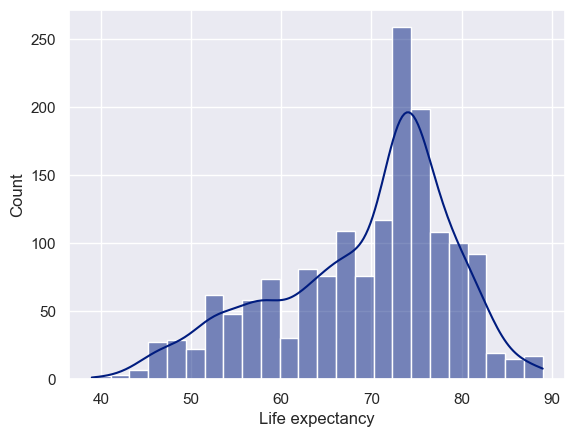

In [64]:
sns.histplot(data=ytrain,kde=True)

Z obrazku je vidno, ze cilova promenna nemuze byt popsana pomoci normalniho rozdeleni. Ted' hisploty pro cely dataset:

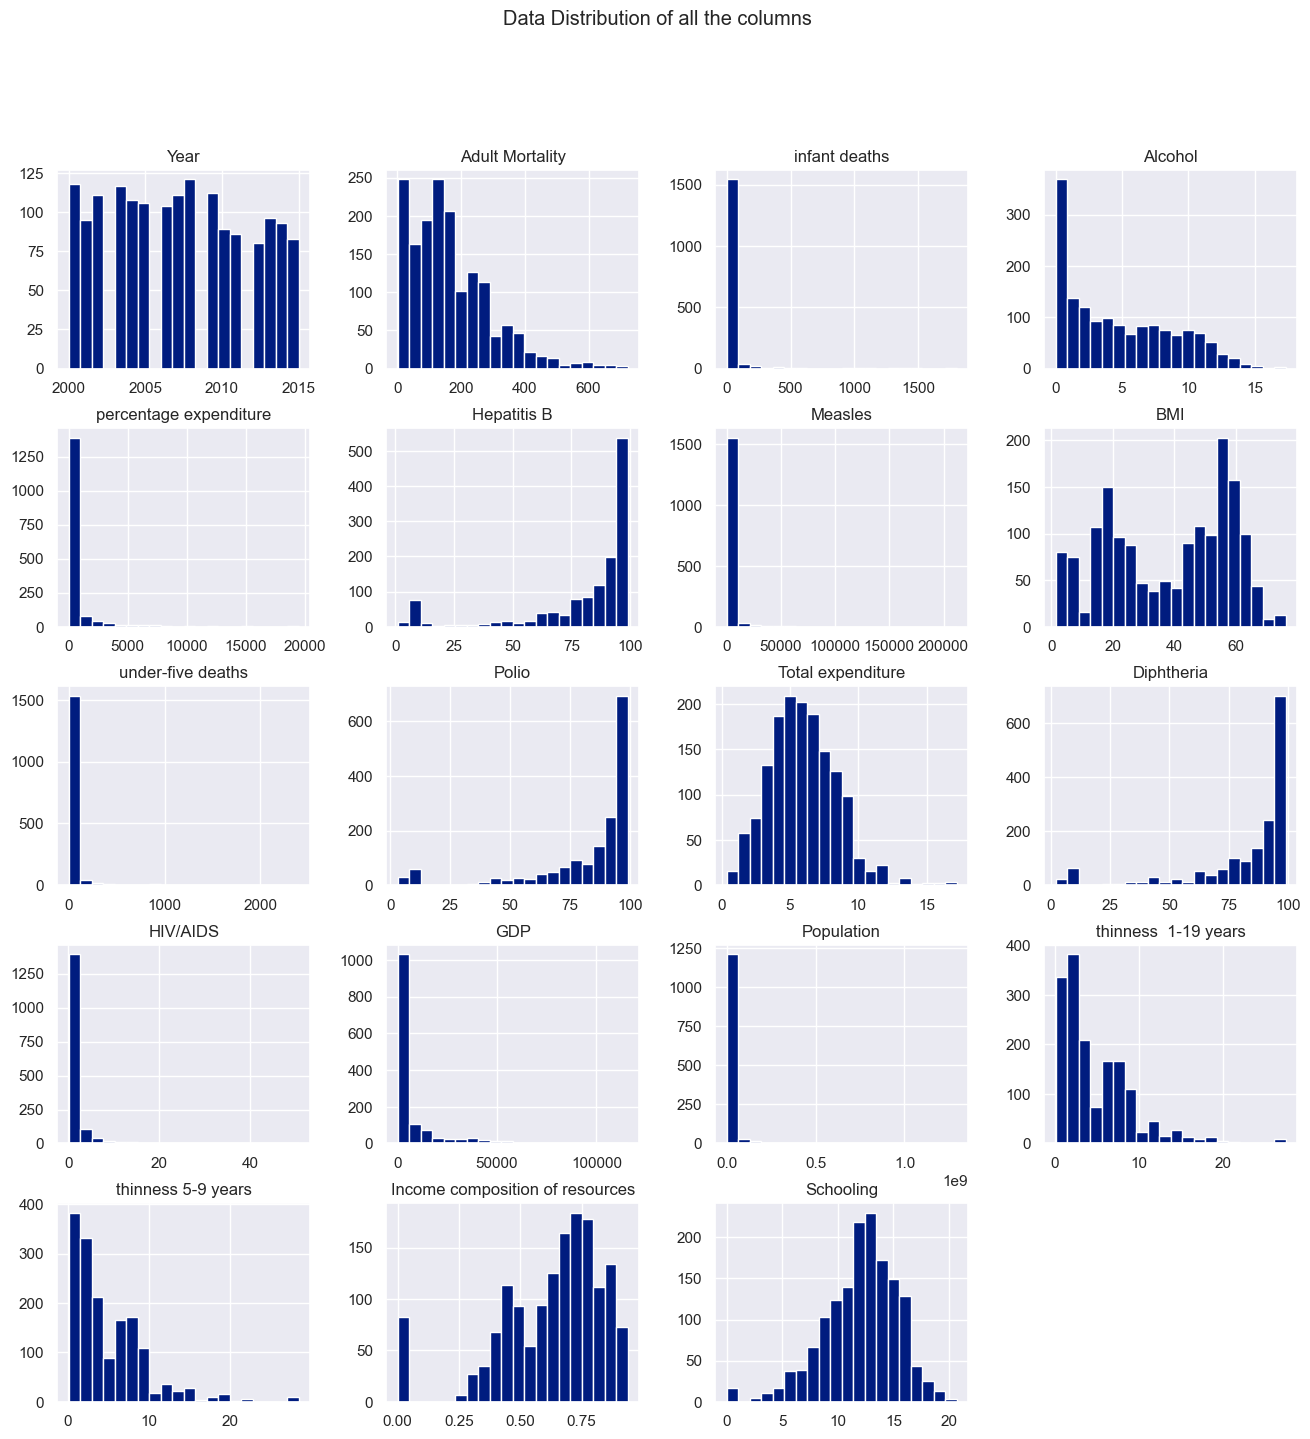

In [65]:
Xtrain.hist(bins=20, figsize=(16,16))
plt.suptitle("Data Distribution of all the columns")
plt.show()

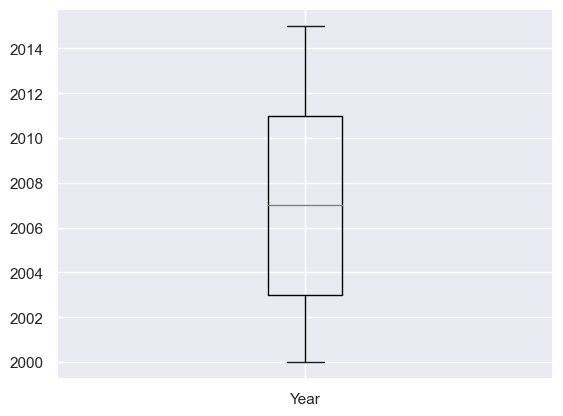

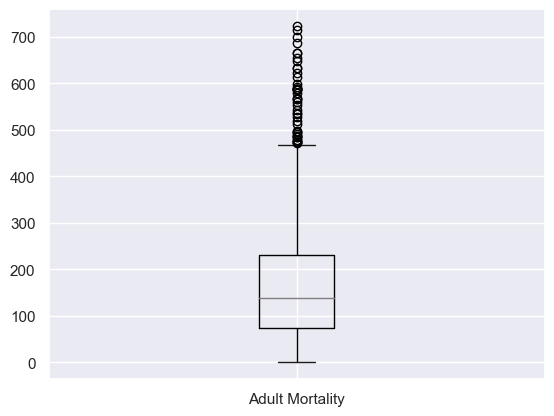

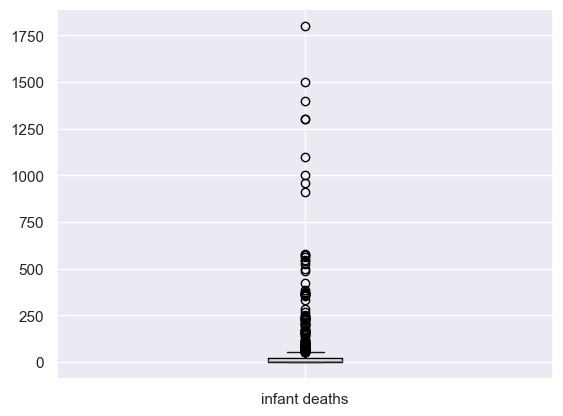

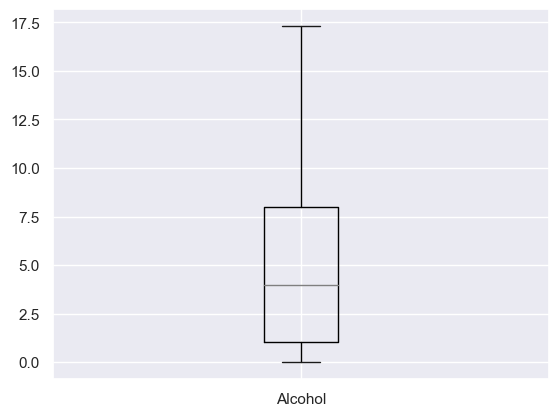

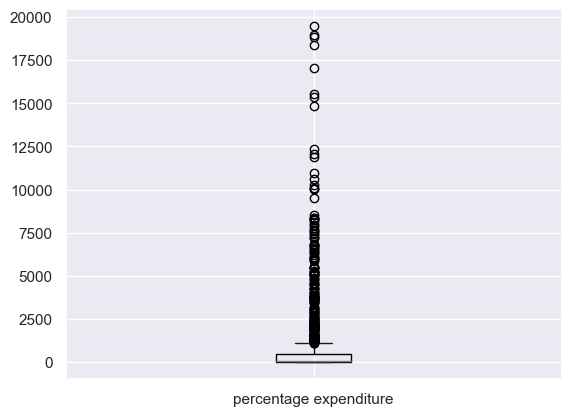

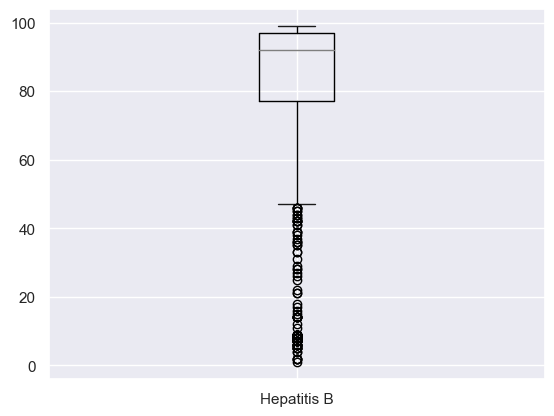

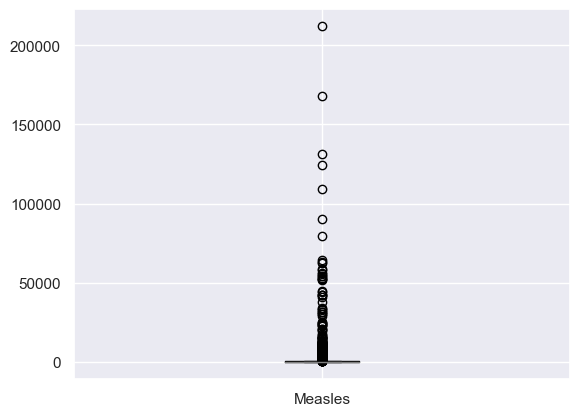

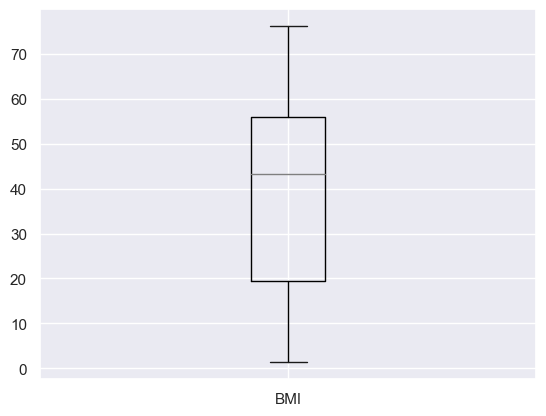

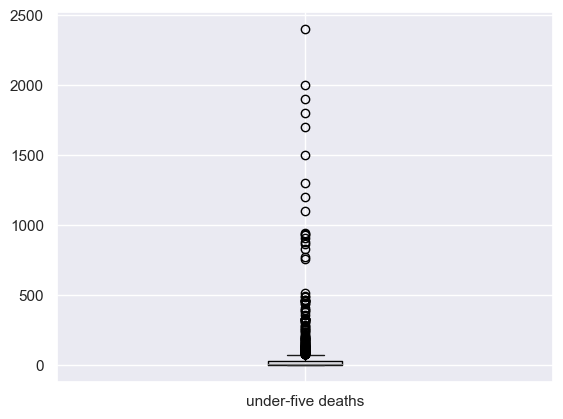

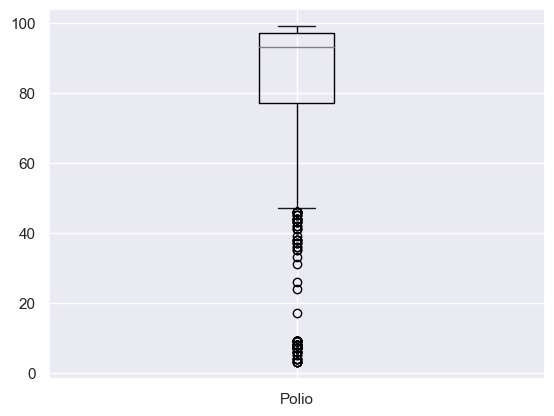

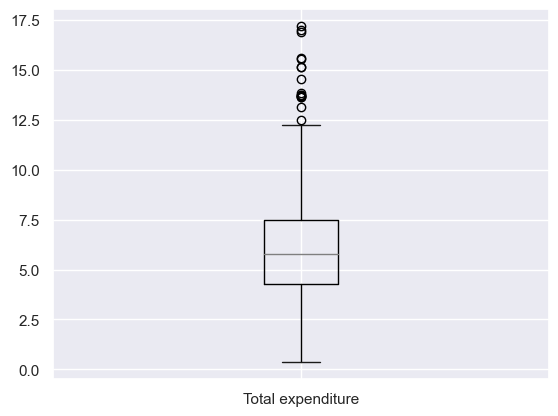

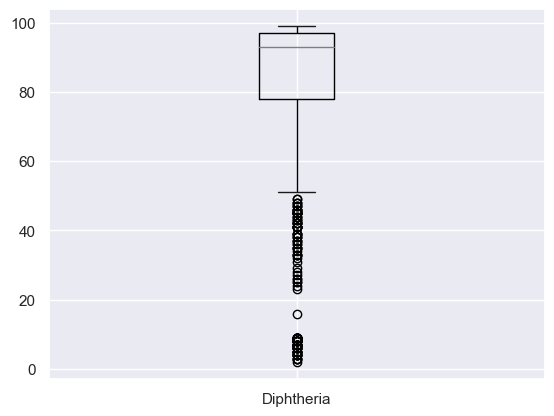

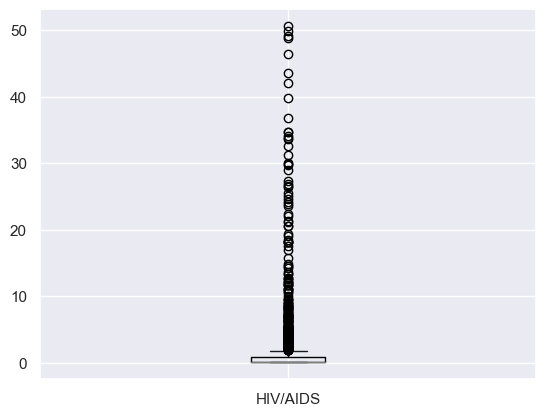

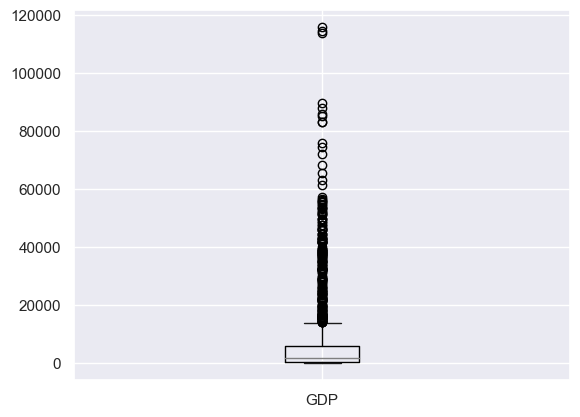

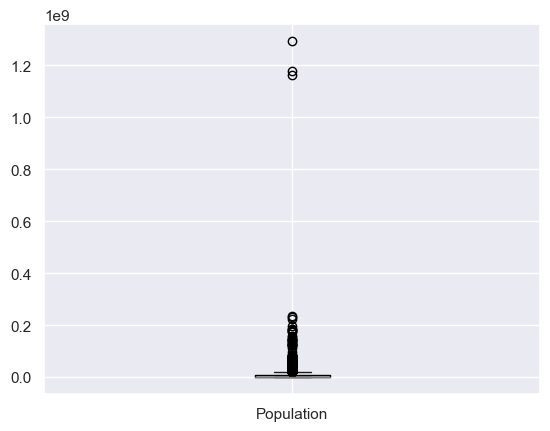

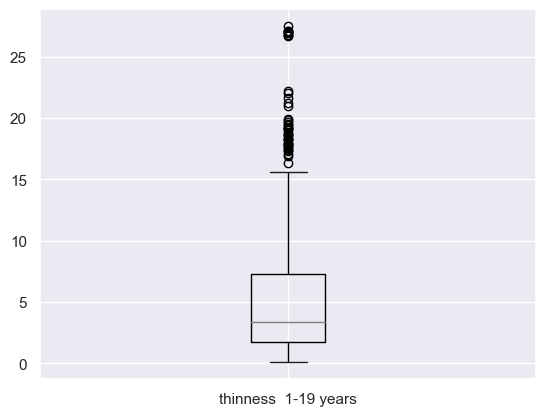

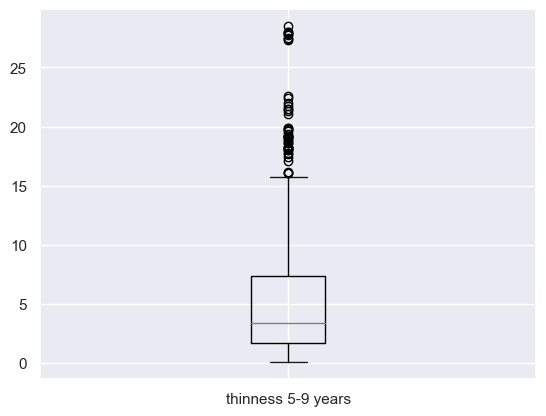

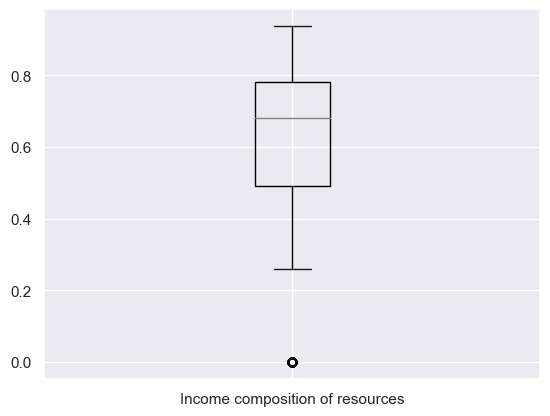

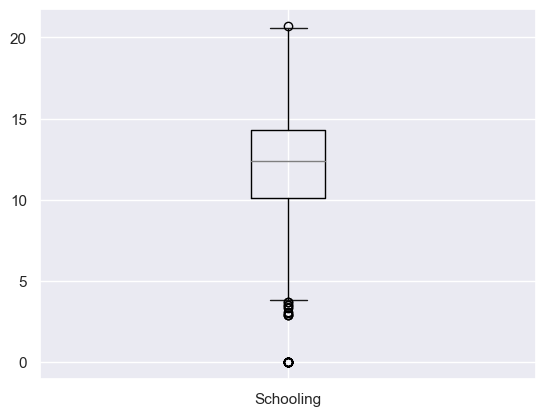

In [66]:
df1 = Xtrain.select_dtypes(exclude=['object'])
for column in df1:
    plt.figure()
    df1.boxplot([column])
plt.show()

<AxesSubplot:xlabel='infant deaths'>

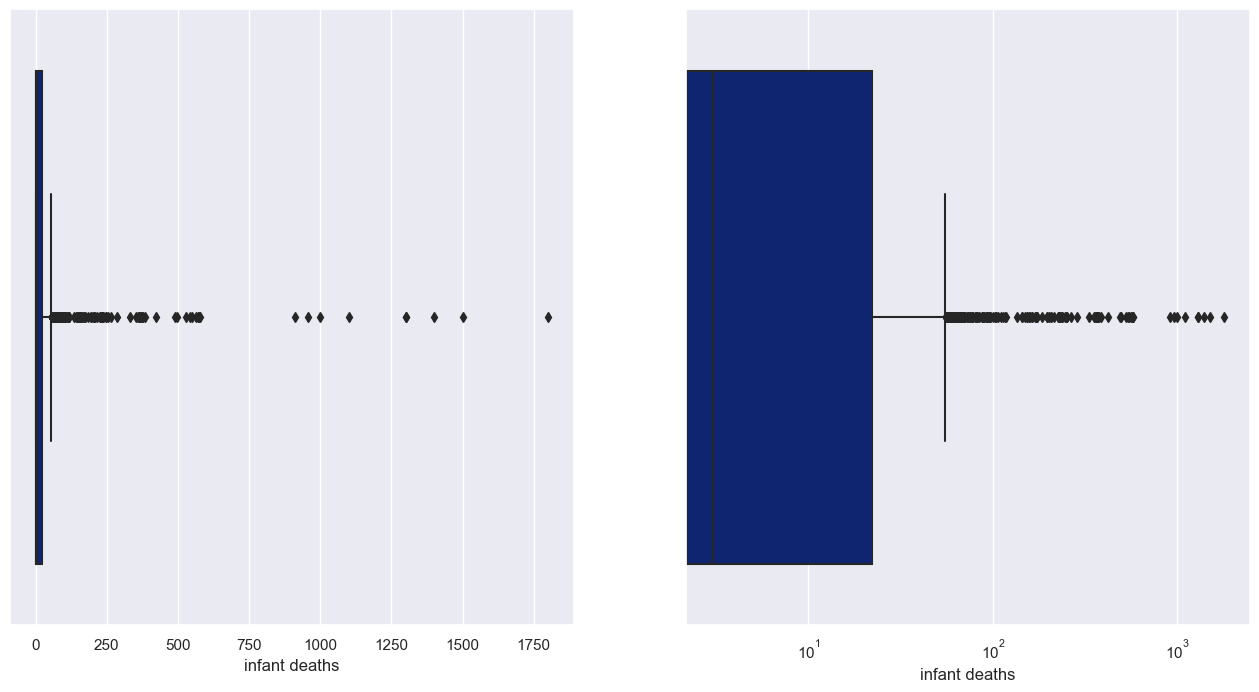

In [67]:
fig, ax = plt.subplots(1,2,figsize=(16,8))
sns.boxplot(data=Xtrain,x="infant deaths",ax=ax[0])
plt.xscale('log')
sns.boxplot(data=Xtrain,x="infant deaths",ax=ax[1])

<AxesSubplot:xlabel='Population'>

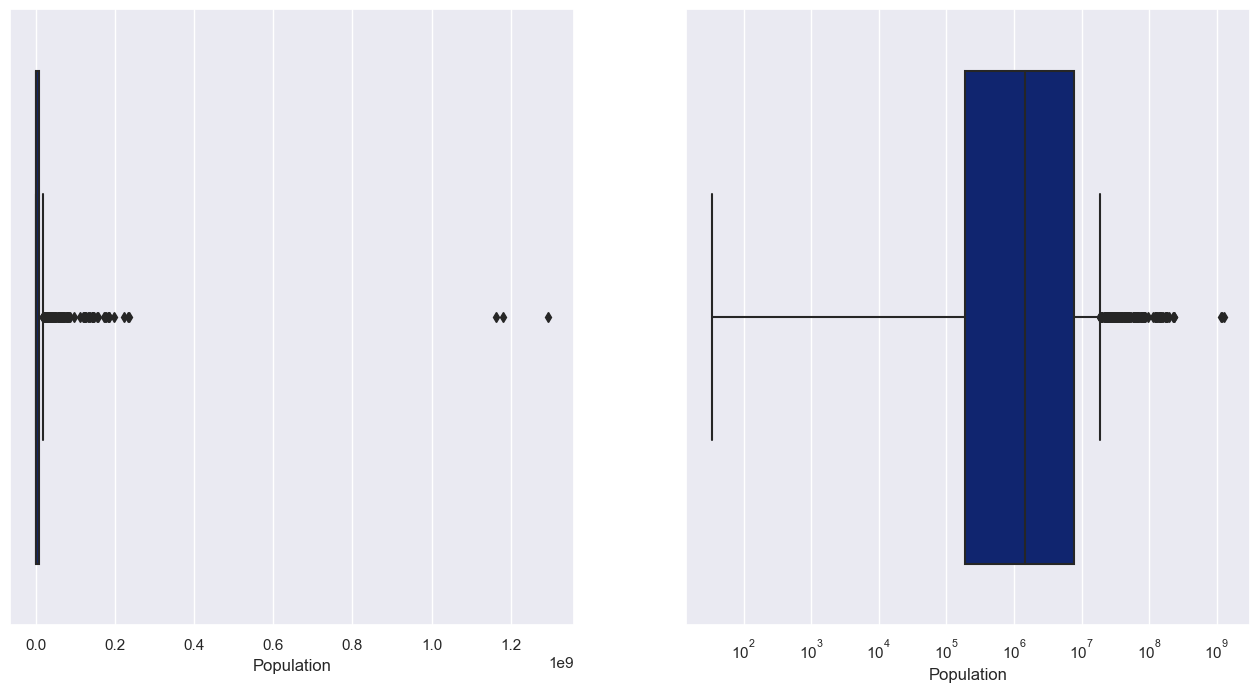

In [68]:
fig, ax = plt.subplots(1,2,figsize=(16,8))
sns.boxplot(data=Xtrain,x="Population",ax=ax[0])
plt.xscale('log')
sns.boxplot(data=Xtrain,x="Population",ax=ax[1])

<AxesSubplot:xlabel='percentage expenditure', ylabel='Count'>

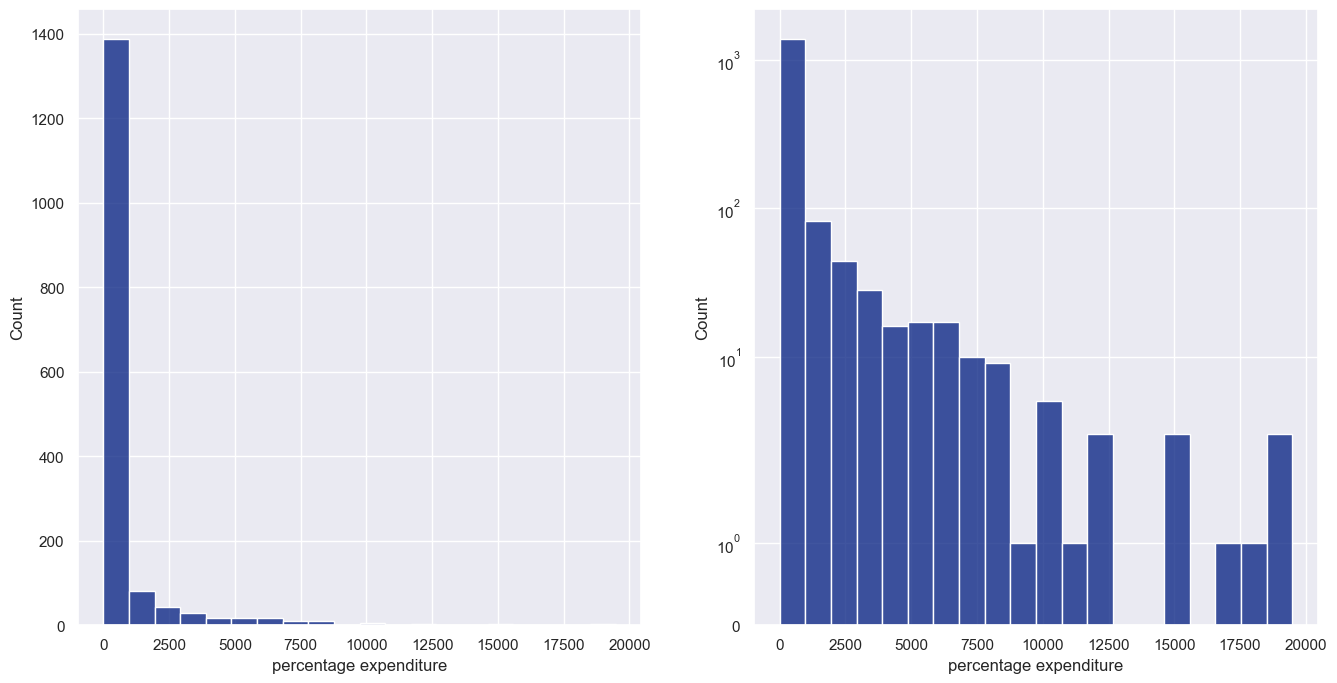

In [69]:
fig, ax = plt.subplots(1,2,figsize=(16,8))
sns.histplot(data=Xtrain,x="percentage expenditure",bins=20,ax=ax[0])
plt.yscale('symlog')
sns.histplot(data=Xtrain,x="percentage expenditure",bins=20,ax=ax[1])

Vidime, ze nektere priznaky maji exponencialni rust(pokles)

Matice korelace:

In [70]:
df.corr().style.background_gradient(cmap='coolwarm')

,Year,Life expectancy,Adult Mortality,infant deaths,Alcohol,percentage expenditure,Hepatitis B,Measles,BMI,under-five deaths,Polio,Total expenditure,Diphtheria,HIV/AIDS,GDP,Population,thinness 1-19 years,thinness 5-9 years,Income composition of resources,Schooling
Year,1.000000,0.179403,-0.088839,-0.034400,-0.033402,0.049329,0.108956,-0.094761,0.120698,-0.040043,0.102543,0.103571,0.136105,-0.136741,0.124655,0.013957,-0.038243,-0.041602,0.256111,0.228680
Life expectancy,0.179403,1.000000,-0.693881,-0.192327,0.395060,0.385182,0.268119,-0.151915,0.565741,-0.218630,0.479179,0.229724,0.487182,-0.557762,0.462631,-0.021464,-0.476904,-0.471579,0.717080,0.749474
Adult Mortality,-0.088839,-0.693881,1.000000,0.074602,-0.185450,-0.244867,-0.173331,0.014699,-0.383845,0.090124,-0.282929,-0.123941,-0.277131,0.522963,-0.295131,-0.014079,0.305737,0.311787,-0.447860,-0.449244
infant deaths,-0.034400,-0.192327,0.074602,1.000000,-0.113039,-0.085907,-0.224849,0.514421,-0.224298,0.996641,-0.167796,-0.127877,-0.171004,0.024421,-0.109735,0.559910,0.481499,0.487284,-0.142930,-0.194832
Alcohol,-0.033402,0.395060,-0.185450,-0.113039,1.000000,0.343834,0.081017,-0.043106,0.321891,-0.109607,0.220511,0.310643,0.221010,-0.047261,0.350592,-0.029160,-0.434867,-0.422320,0.441255,0.546588
percentage expenditure,0.049329,0.385182,-0.244867,-0.085907,0.343834,1.000000,0.029549,-0.056848,0.230092,-0.088134,0.151722,0.186154,0.147655,-0.100155,0.898738,-0.024372,-0.257370,-0.259112,0.384741,0.396312
Hepatitis B,0.108956,0.268119,-0.173331,-0.224849,0.081017,0.029549,1.000000,-0.133452,0.157076,-0.234529,0.496905,0.062976,0.594214,-0.120823,0.096623,-0.127255,-0.130170,-0.135297,0.207271,0.226267
Measles,-0.094761,-0.151915,0.014699,0.514421,-0.043106,-0.056848,-0.133452,1.000000,-0.172887,0.522251,-0.143602,-0.097267,-0.148046,0.024716,-0.078041,0.268308,0.247403,0.239655,-0.130466,-0.141977
BMI,0.120698,0.565741,-0.383845,-0.224298,0.321891,0.230092,0.157076,-0.172887,1.000000,-0.234782,0.286964,0.244528,0.288318,-0.243511,0.301941,-0.070086,-0.532348,-0.539445,0.504093,0.559990
under-five deaths,-0.040043,-0.218630,0.090124,0.996641,-0.109607,-0.088134,-0.234529,0.522251,-0.234782,1.000000,-0.186325,-0.129891,-0.191946,0.037252,-0.113320,0.548088,0.483482,0.488107,-0.160736,-0.210004


Zajimave momenty:
- priznak "under-five deaths" ma corelace 0.99 z priznakem "infant deaths" - muzeme zahodit jeden z nich, cimz zmensime dimenzialitu
- priznak "thinness 1-19 years" ma corelace 0.937015 z priznakem "thinness 5-9 years" - je smysl je spojit, cimz zmensime dimenzialitu
- Jine combinace:
    - "Income composition of resources" a "Schooling" (0.795102)
    - "percentage expenditure" a "GPD" (0.898738)
    - "Diphtheria" a "Polio" (0.685924)

Jak vidime, cilova promnenna ma vysokou korelace z priznaky "BMI", "Income composition of resources", "Schooling" a "Adult Mortality". Pojdme to vykreslit: 

In [71]:
def create_scatterplot(x_axis, column_name):
    
    plt.figure(figsize=(15, 20))

    for index, col in enumerate(column_name):
        plt.subplot((len(column_name) + 1) // 2, 2, index+1) # create sub-plot
    
        sns.scatterplot(x=x_axis, y=col, data=df)
        
        plt.title(col) 
        plt.xlabel("")
        plt.ylabel("")

    plt.tight_layout(pad=2)

    plt.show()

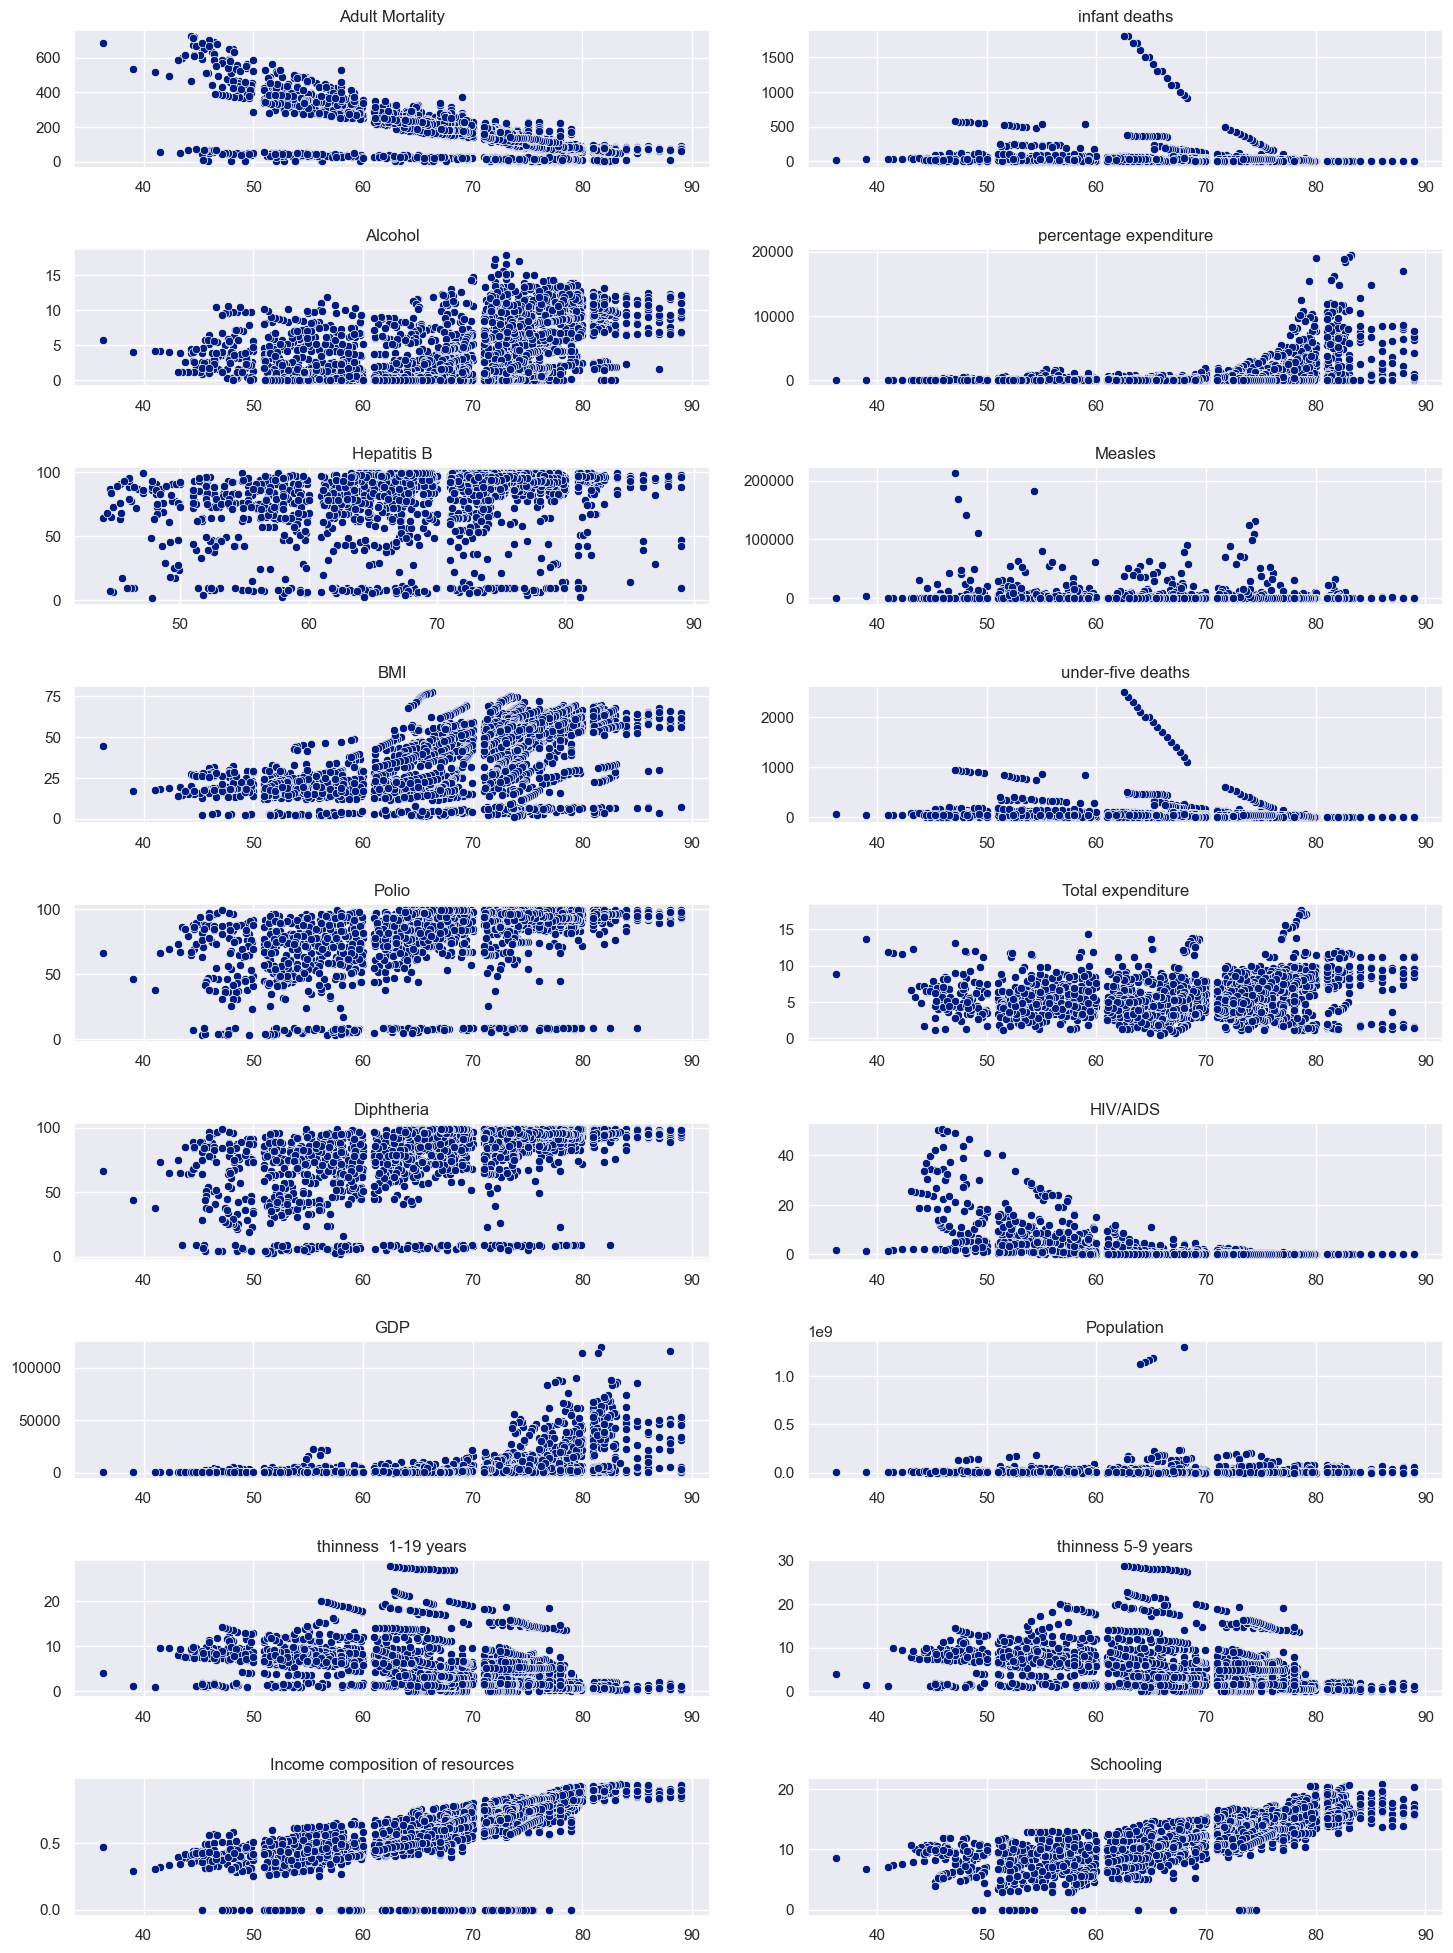

In [72]:
create_scatterplot("Life expectancy",df.drop(columns=["Status","Country","Life expectancy","Year"]).columns.tolist())

Z toho je videt nekolik docela zajimavych momentu:
- Nejvyssi hodnoty nekterych priznaku (napriklad "thinnes 5-9 years", "Population", "under-five deaths", "BMI")zaruci ze hodnota "Life expectancy" bude v rozmezi od 60 do 70 let
- Jine priznaky ("Schooling", ""Income compostion of resources", "GDP", "percentage expenditure", "Total expenditure") urcuji rozmezi od 80 do 90 let
- "Adult mortality" opravdu negativne ovlivnuje target priznak: cim vetsi hodnota "Adult mortality", tim mensi hodnota "Life expectancy"

Ted' prozkoumame vliv categorickych dat a priznaku "Year" na "Life expectancy":

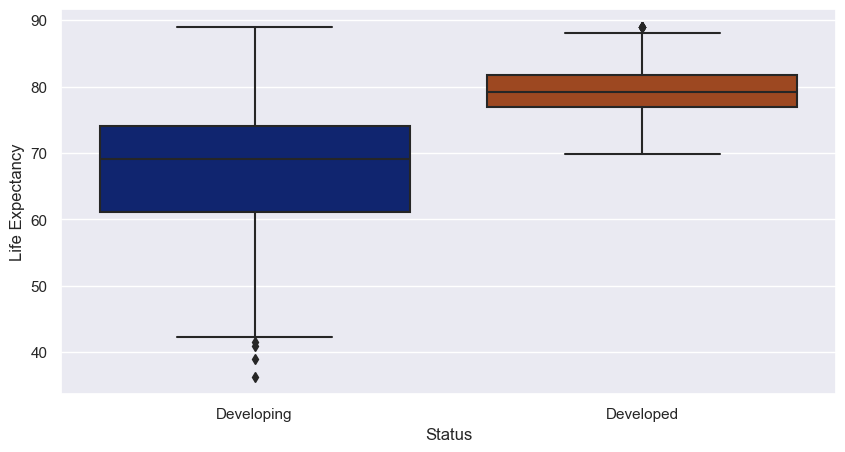

In [73]:
plt.figure(figsize=(10,5))
sns.boxplot(x="Status", y="Life expectancy", data=df)
plt.xlabel("Status")
plt.ylabel("Life Expectancy")
plt.show()

U "Developed" zemí je rozsah možného věku velmi malý - s velkou přesností můžeme říci, že developed země má "Life expectancy" nejméně 70 let. Zároveň je u "developing" zemí tento rozsah příliš velký.

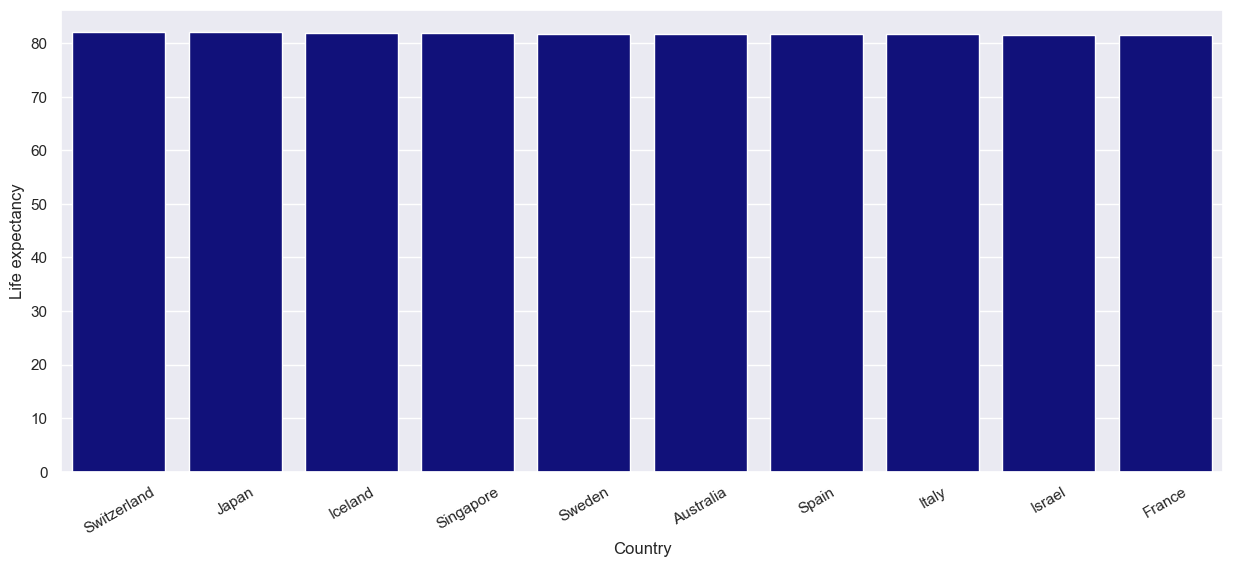

In [74]:
# see top 10 country of Life Expectancy
country = df.groupby("Country")["Life expectancy"].median().sort_values(ascending = False).reset_index()

# Create the bar plot
plt.figure(figsize=(15, 6))
sns.barplot(x='Country', y='Life expectancy', data=country.head(10), color="darkblue")

plt.xticks(rotation = 30)

# Show the plot
plt.show()

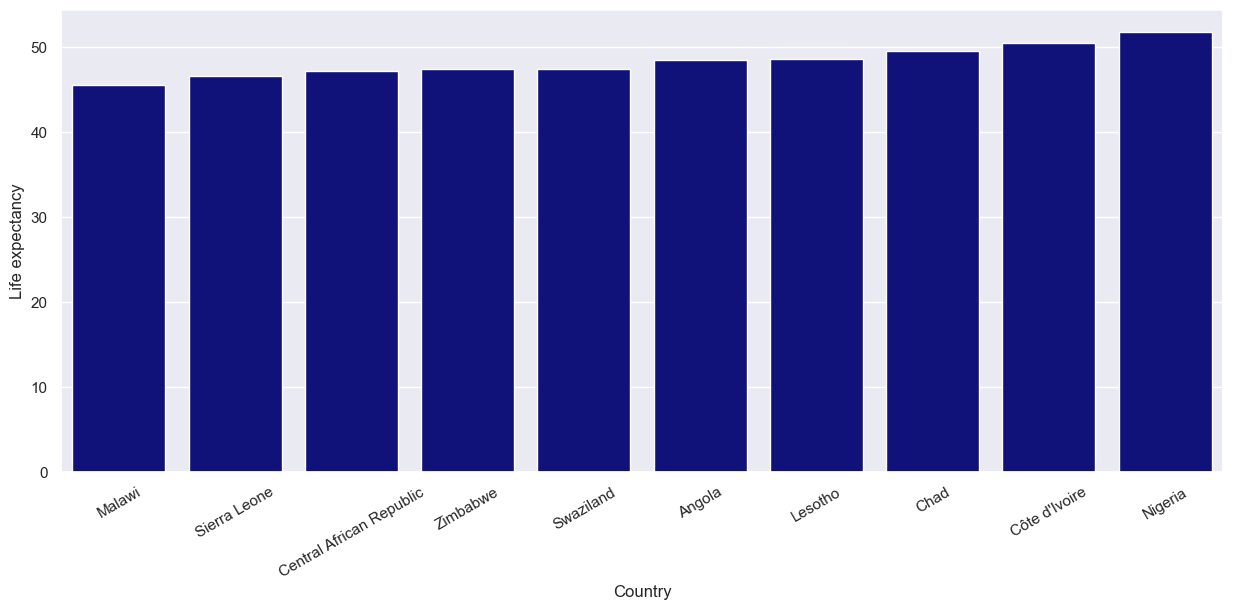

In [75]:
country = df.groupby("Country")["Life expectancy"].median().sort_values(ascending = True).reset_index()

plt.figure(figsize=(15, 6))
sns.barplot(x='Country', y='Life expectancy', data=country.head(10), color="darkblue")

plt.xticks(rotation = 30)

plt.show()

Vidíme, že země s nejvyšší délkou života se nacházejí v různých částech světa. Zároveň mohou mít země ze stejné části světa radikálně odlišné ukazatele (např. Japonsko a Indie). Proto nemůžeme země kategorizovat podle hlavních částí světa. Musíme buď vytvořit více kategorií, nebo kódovat jinak.

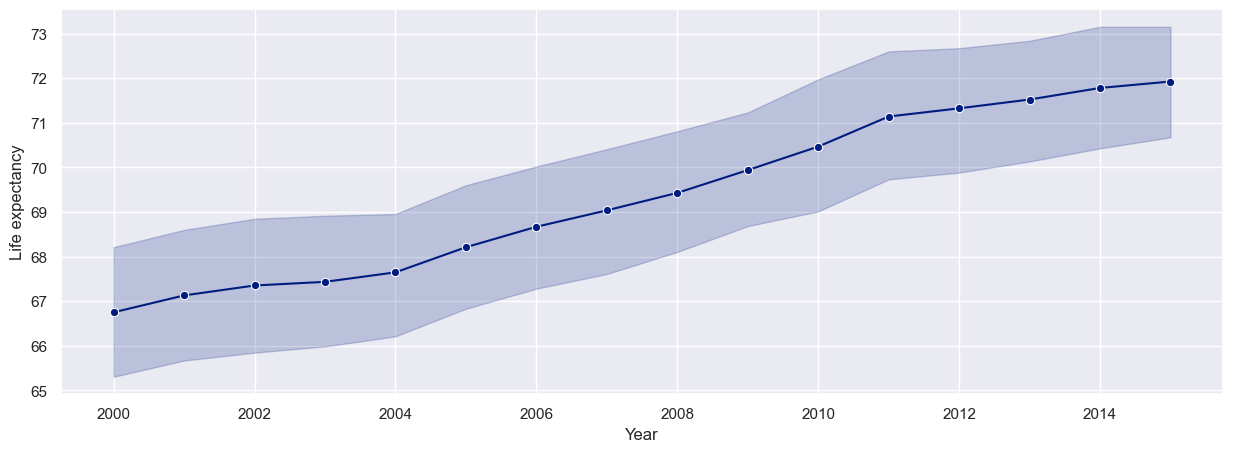

In [76]:
plt.figure(figsize=(15,5))

sns.lineplot(x='Year', y='Life expectancy', data=df, marker='o')
plt.show()

V průběhu času se očekávaná délka života v průměru prodlužuje - což je předvídatelné.

# Predzpracovani dat

## Trenovaci

Z boxplotů vidime, ze nektere priznaky maji hodnoty, ktere jsou vyrazne vyssi, než jsou povolené limity (nejlepší příklad - "Measles", počet hlášených případů na 1000 obyvatel, ale existuji data z hodnotou > 5000). Rešením je omezit hodnoty:

In [77]:
def limit_for_1000(x):
      if pd.isnull(x):
            return x
      elif x > 1000:
            return 1000
      elif x < 0:
            return 0
      else:
            return x

In [78]:
def limit_for_100(x):
      if pd.isnull(x):
            return x
      elif x > 100:
            return 100
      elif x < 0:
            return 0
      else:
            return x

In [79]:
cols_1000 = ["Adult Mortality","infant deaths","Measles","under-five deaths","HIV/AIDS"]

# "percentage expenditure" and "Total expenditure" are not on the list
# Because data are given as a percentage of gross domestic product per capita
# respectively, as percentage of total government spending
# That means, value can be more than 100%
cols_100 = ["Hepatitis B","Polio","Diphtheria"]

for col in cols_1000:
      Xtrain[col] = Xtrain[col].apply(limit_for_1000)
for col in cols_100:
      Xtrain[col] = Xtrain[col].apply(limit_for_100)

Overime, ze nema chybejicich hodnot:

<AxesSubplot:xlabel='Count', ylabel='index'>

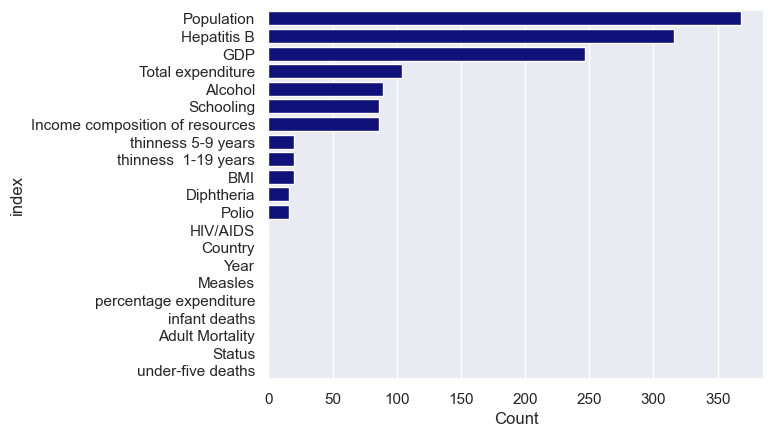

In [80]:
sns.set_theme(palette='dark',style='darkgrid')
nans = Xtrain.isnull().sum().reset_index(name="Count").sort_values(by="Count",ascending=False)
sns.barplot(data=nans,y="index",x="Count",color='darkblue')

Před kódováním doplníme nulové hodnoty pomocí stredni hodnoty priznaku:

In [81]:
mean_by_columns = {}

nans = nans.iloc[np.where(nans['Count'].array > 0)]['index'].array
for col in nans:
      mean_by_columns[col] = Xtrain[col].mean();
      Xtrain[col] = Xtrain[col].fillna(mean_by_columns[col])

<AxesSubplot:xlabel='Count', ylabel='index'>

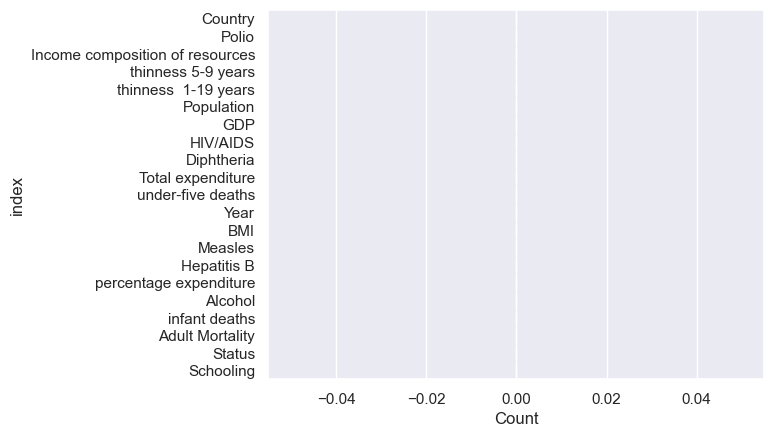

In [82]:
nans = Xtrain.isnull().sum().reset_index(name="Count").sort_values(by="Count",ascending=False)
sns.barplot(data=nans,y="index",x="Count",color='darkblue')

Ted preskalujeme nektere priznaky pomoci log meritka a PowerTransformer. Tim zarucime že rozdělení bude více Gaussovské (a lineární regrese bude lépe předpovídat výsledek).


Podle https://scikit-learn.org/stable/auto_examples/preprocessing/plot_all_scaling.html#:%7E:text=QuantileTransformer%20provides%20non%2Dlinear%20transformations,stabilize%20variance%20and%20minimize%20skewness :

"PowerTransformer applies a power transformation to each feature to make the data more Gaussian-like in order to stabilize variance and minimize skewness."

Pouziti PowerTransformer by nemělo ovlivnit predikci ani narušit jakékoli vztahy mezi prznaky, naopak by to mělo zvýšit symetrii distribici priznaků.

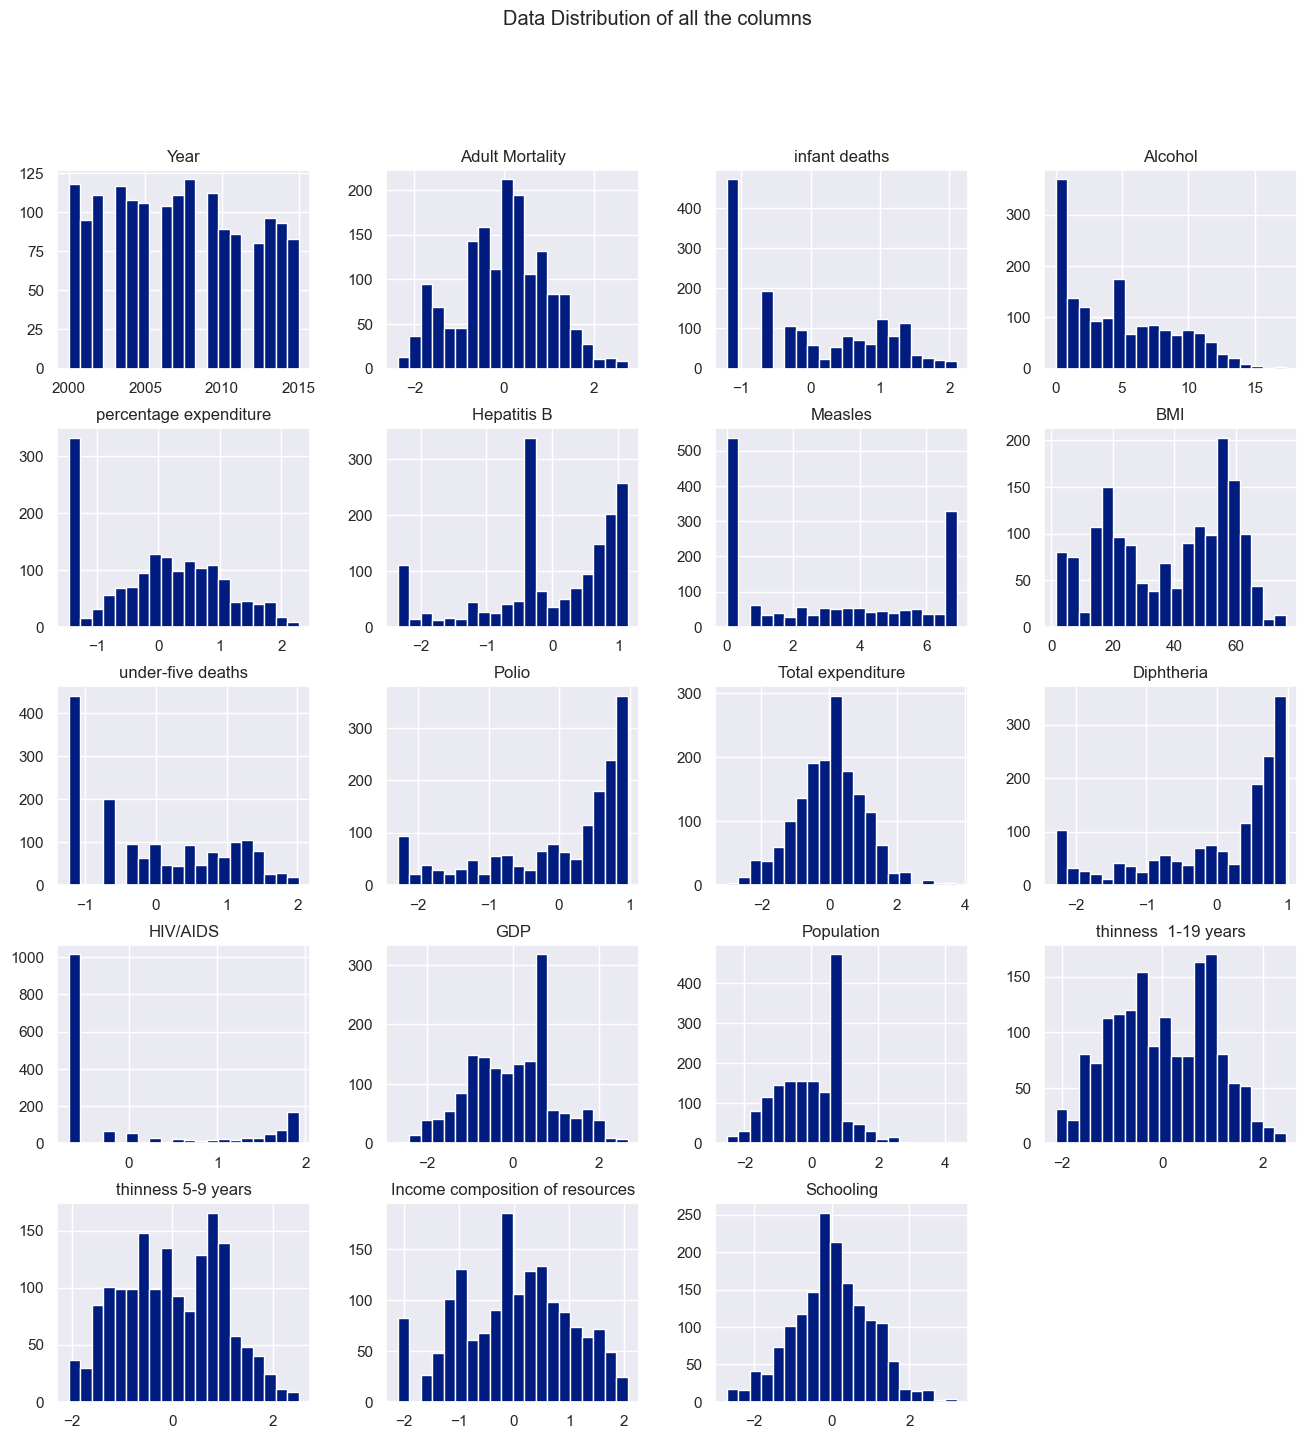

In [83]:
power_cols = ['Adult Mortality','infant deaths','percentage expenditure',
               'Hepatitis B','under-five deaths','Polio','Total expenditure','Diphtheria',
               'HIV/AIDS','GDP','Population','thinness  1-19 years','thinness 5-9 years',
               'Income composition of resources','Schooling']
log_cols = ['Measles']

power_tr = {}
for col in power_cols:
      power_tr[col] = PowerTransformer()
      power_tr[col].fit(Xtrain[col].array.reshape(-1, 1))
      Xtrain[col] = power_tr[col].transform(Xtrain[col].array.reshape(-1, 1))

log_tr = {}
for col in log_cols:
      log_tr[col] = FunctionTransformer(np.log1p)
      log_tr[col].fit(Xtrain[col].array.reshape(-1, 1))
      Xtrain[col] = log_tr[col].transform(Xtrain[col].array.reshape(-1, 1))

Xtrain.hist(bins=20, figsize=(16,16))
plt.suptitle("Data Distribution of all the columns")
plt.show()

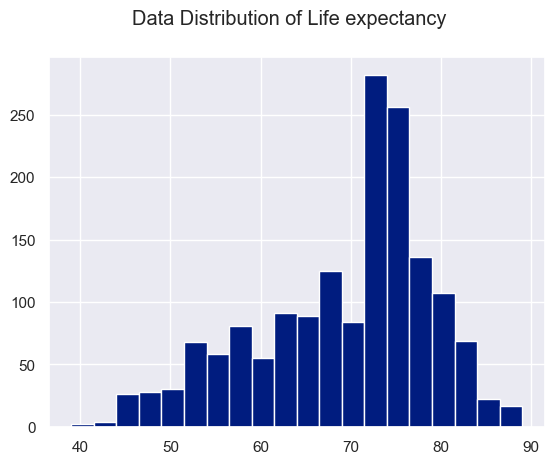

In [84]:
ytrain.hist(bins=20)
plt.suptitle("Data Distribution of Life expectancy")
plt.show()

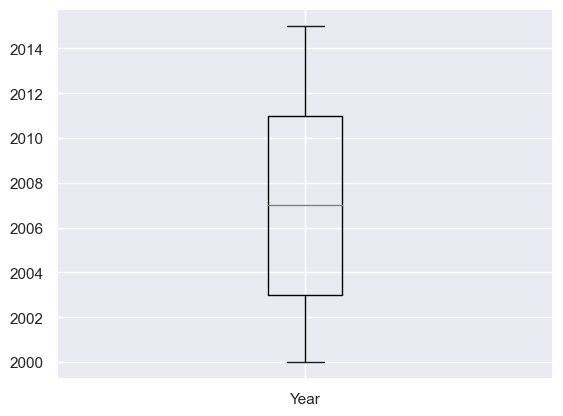

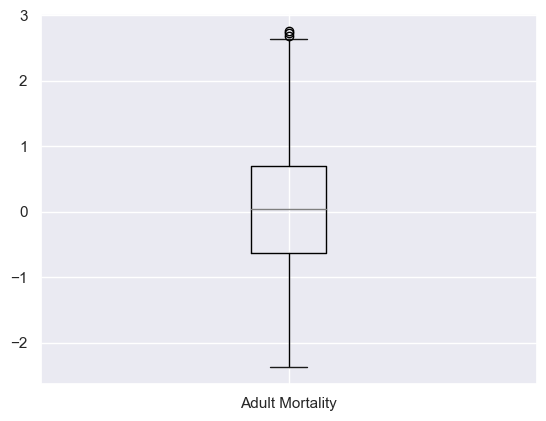

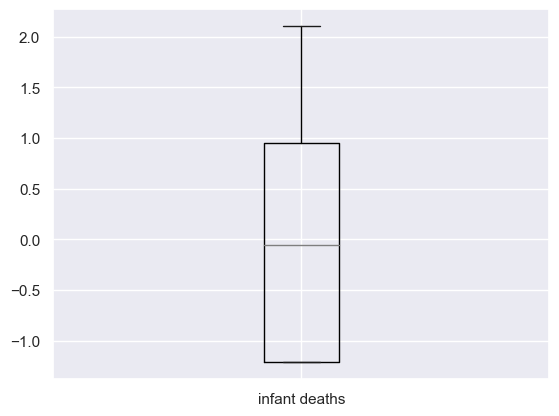

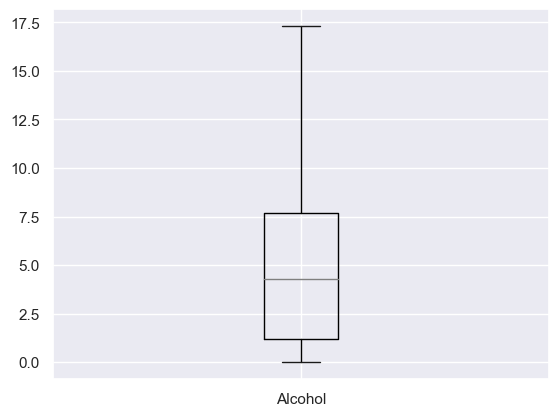

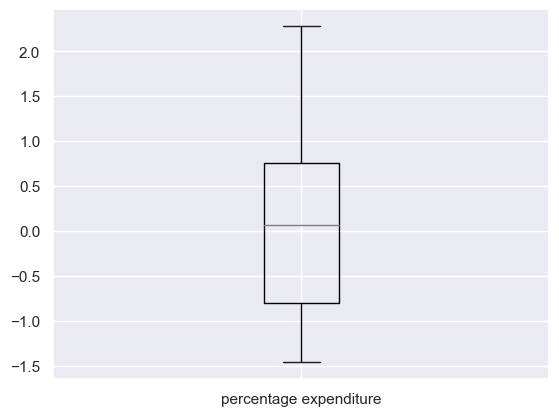

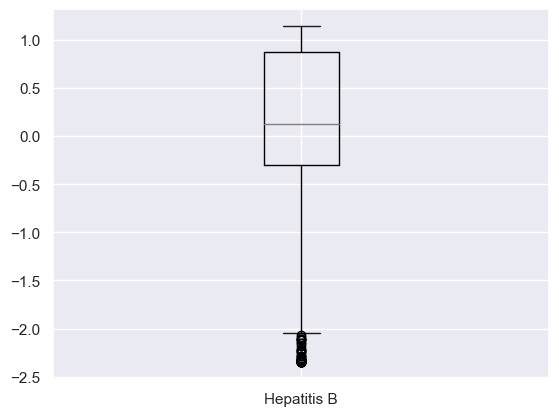

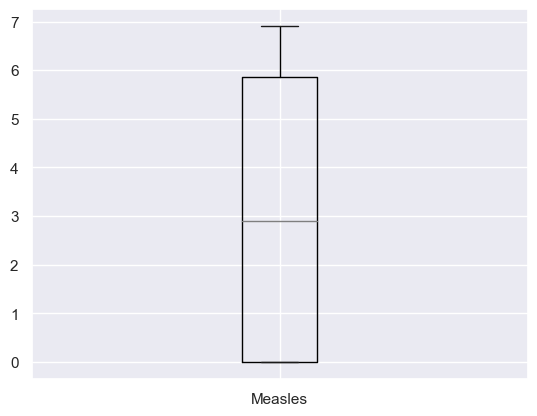

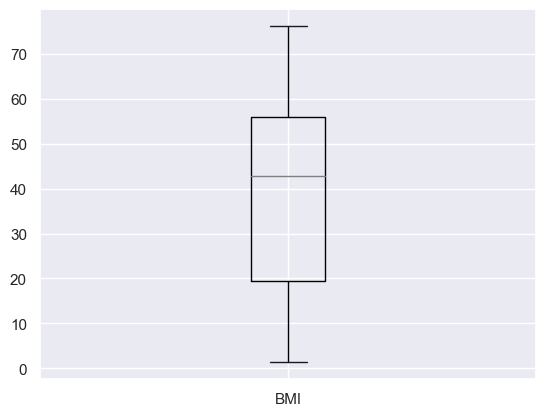

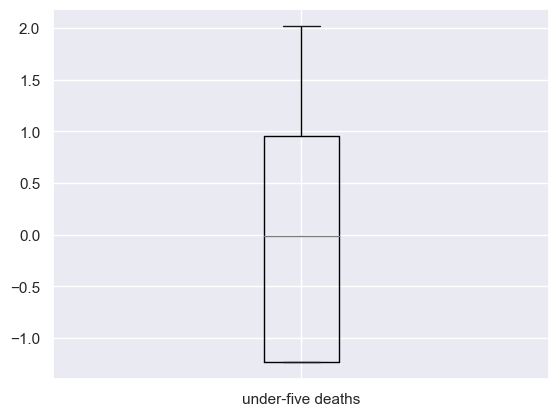

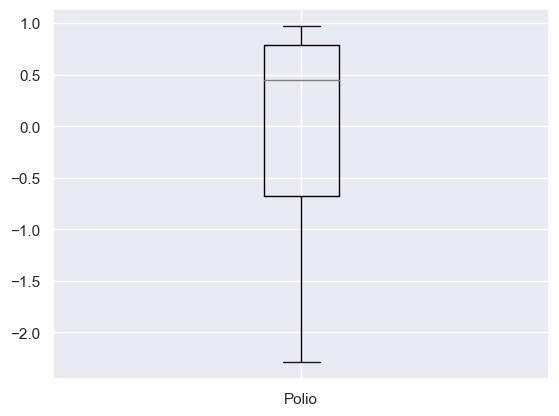

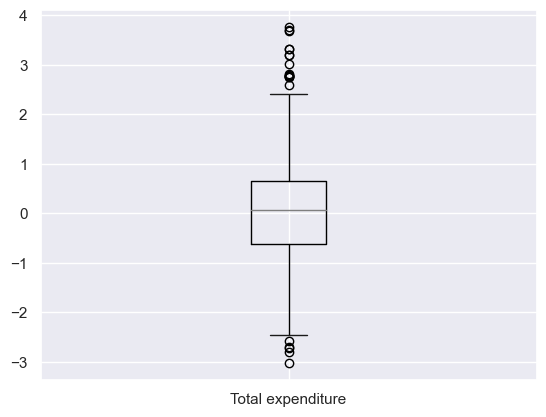

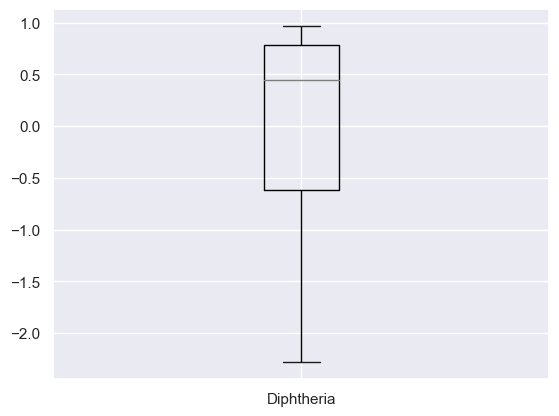

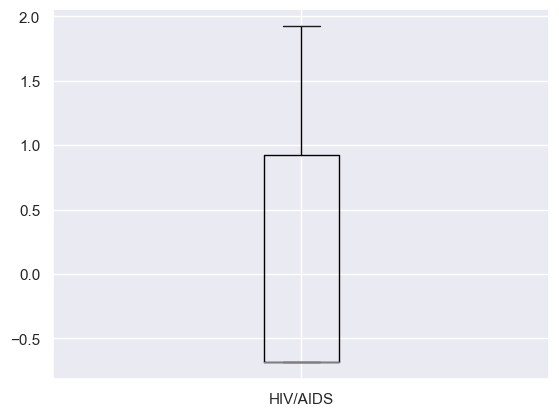

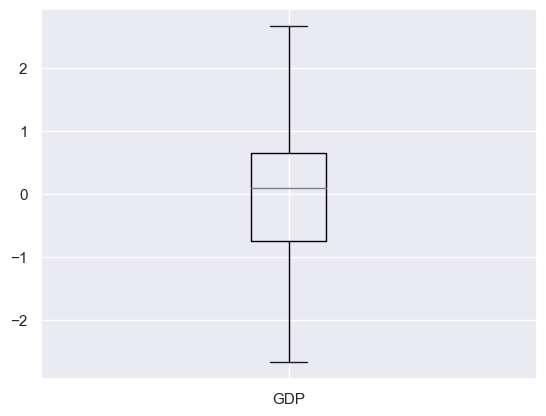

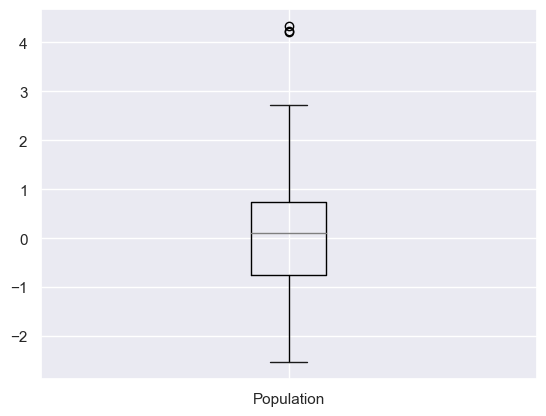

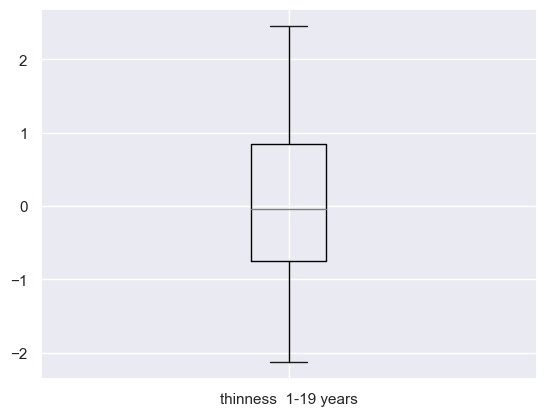

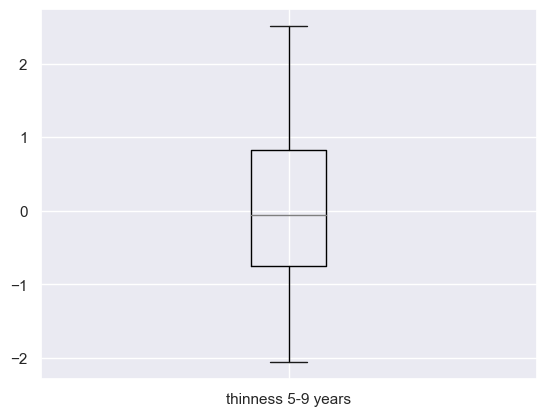

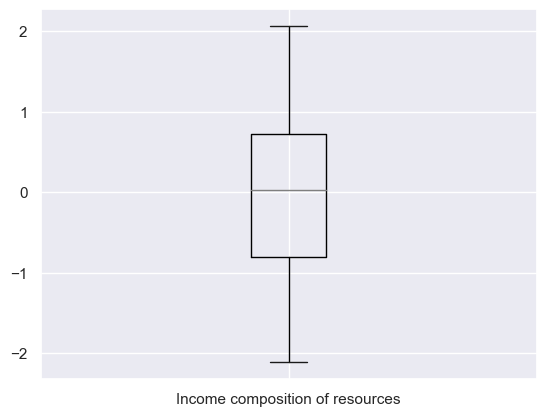

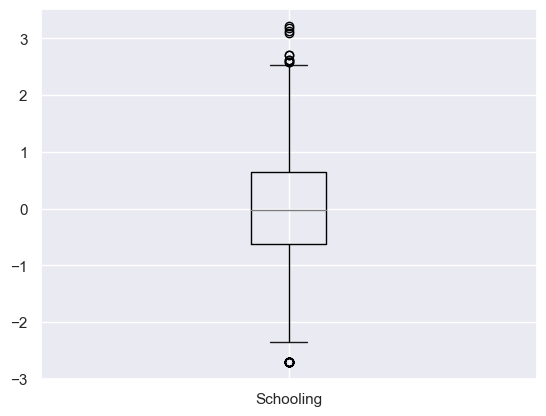

In [85]:
df1 = Xtrain.select_dtypes(exclude=['object'])
for column in df1:
    plt.figure()
    df1.boxplot([column])
plt.show()

Z predchozich grafu vidime, ze nas dataset obsahuje spoustu outliers, musime s tim nejak poradit:

In [86]:
min_max_q_bycolumn = {}
# Remove object columns
data= Xtrain.drop(["Country", "Status"], axis=1)
columns= data.columns.to_list()

outliers=[]

for col in columns:
    q1 = Xtrain[col].quantile(0.25)
    q3 = Xtrain[col].quantile(0.75)
    
    min_q = q1-1.5*(q3-q1)
    max_q = q3+1.5*(q3-q1)
    min_max_q_bycolumn[col] = [min_q,max_q]
    for pos in range(len(data)):
        if data[col].iloc[pos] > max_q or data[col].iloc[pos]< min_q:
            outliers.append(pos)
            
# remove the duplicate values
outliers=set(outliers)
outliers=list(outliers)

# Drop the outliers from our dataset
Xtrain.drop(Xtrain.index[outliers], inplace=True)
ytrain.drop(ytrain.index[outliers], inplace=True)

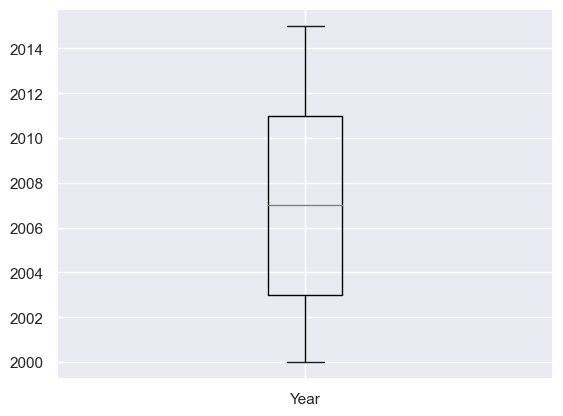

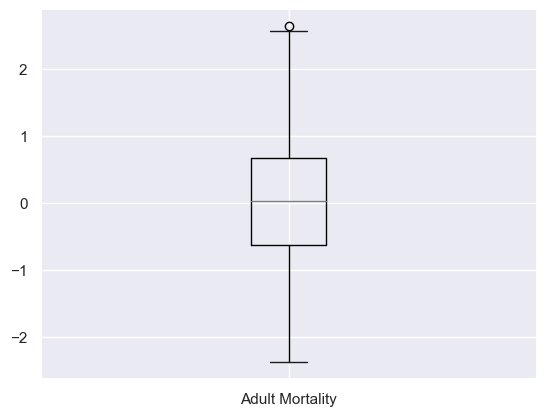

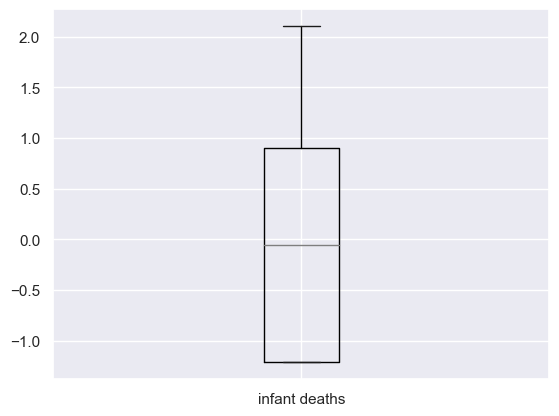

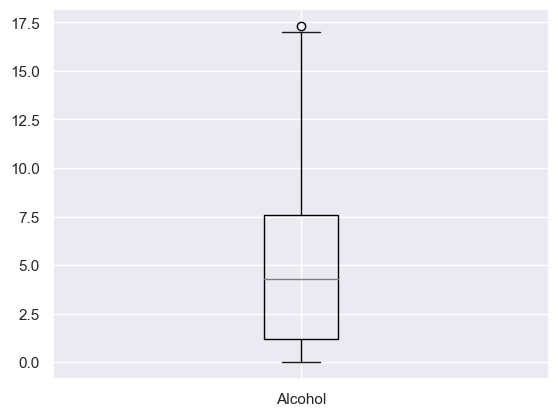

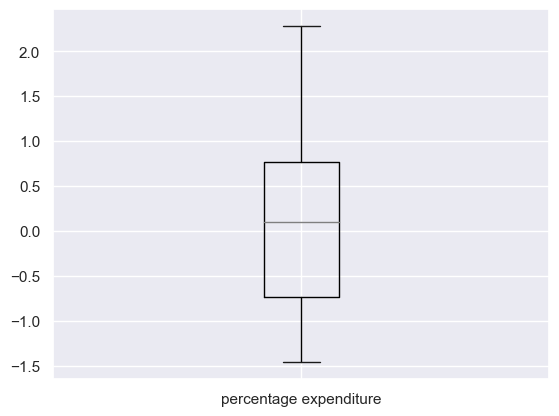

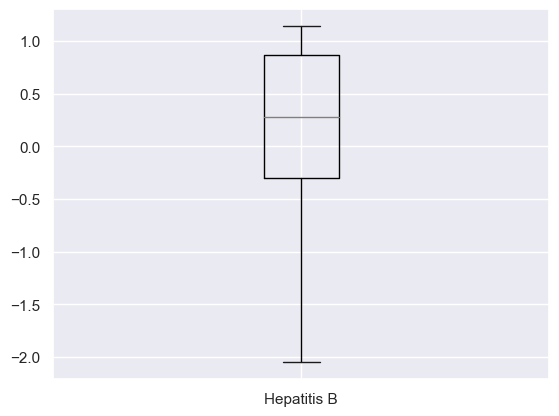

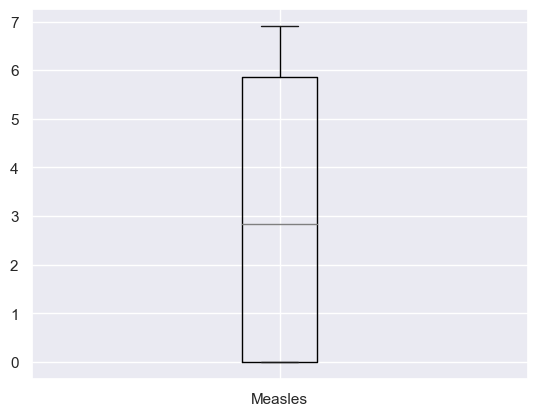

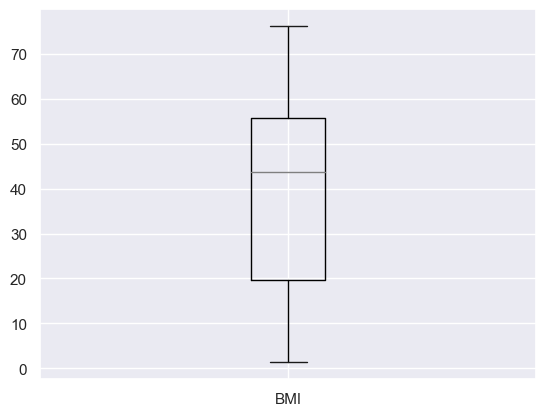

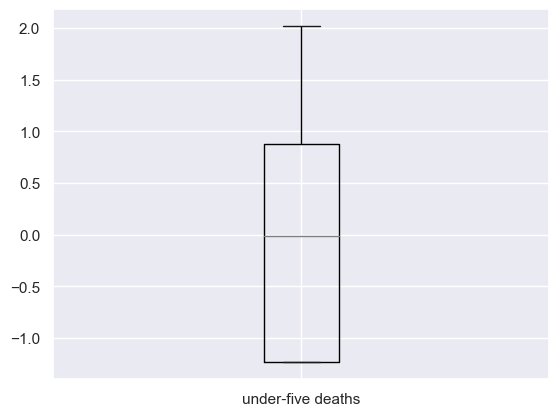

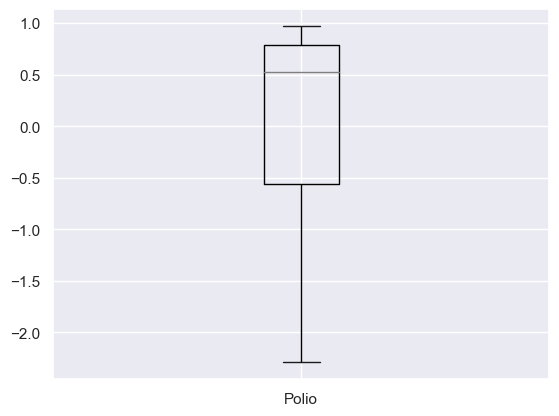

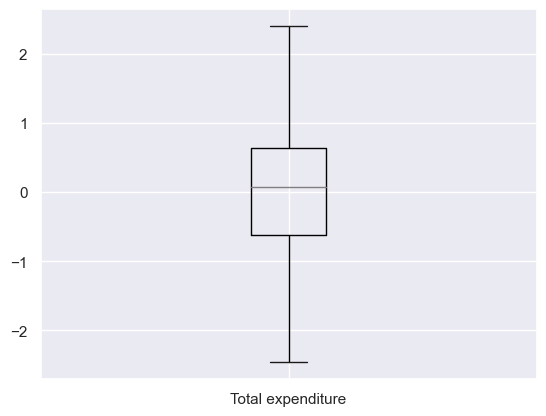

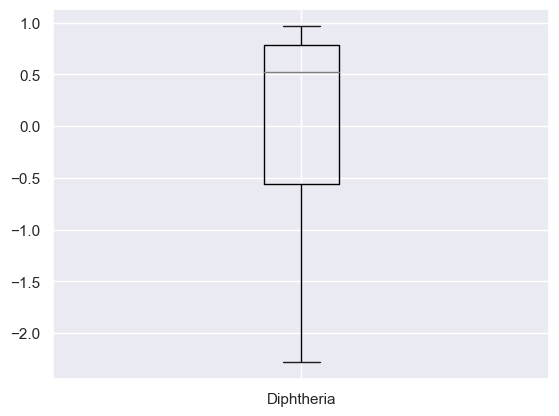

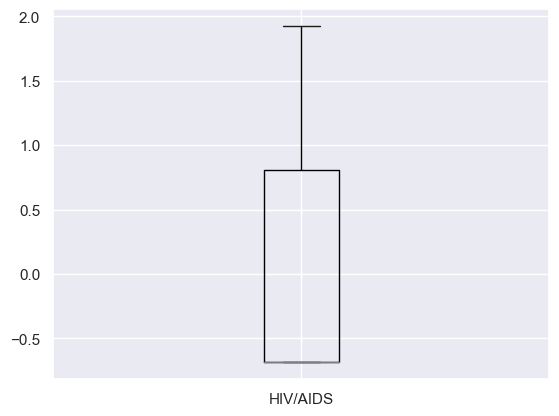

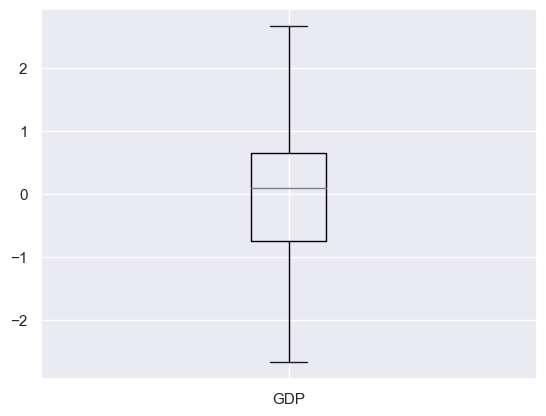

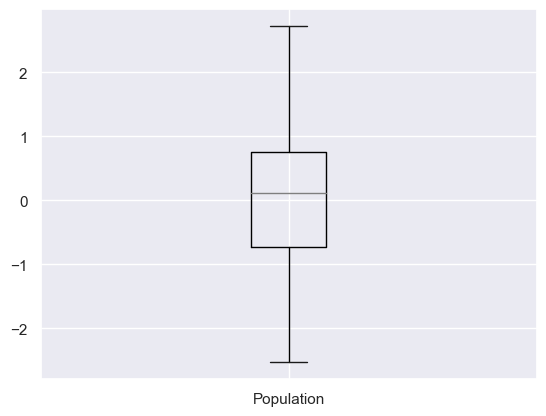

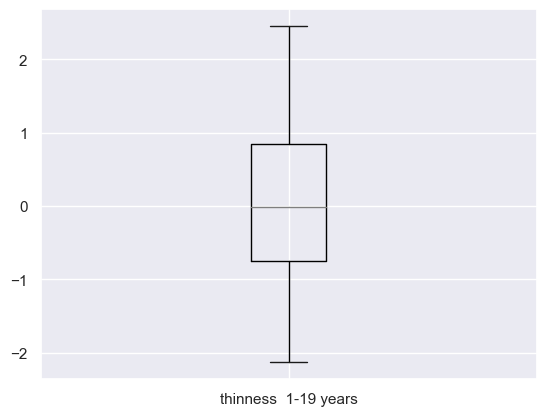

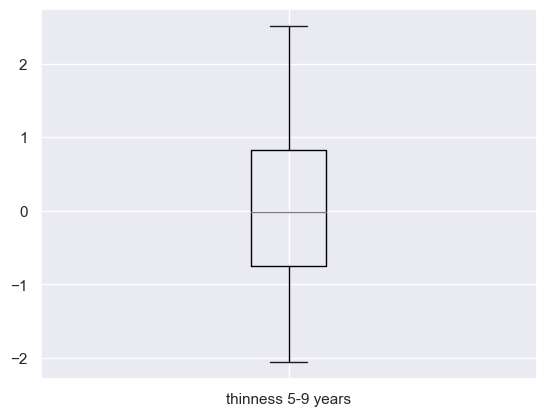

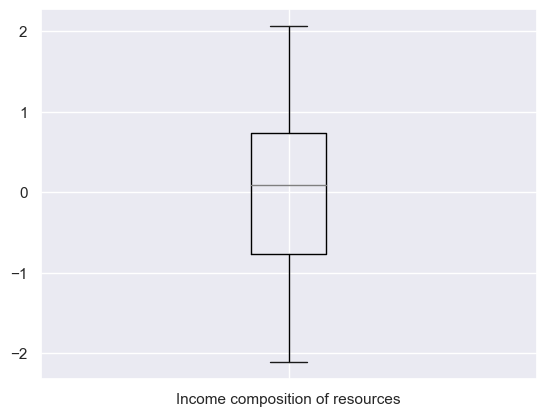

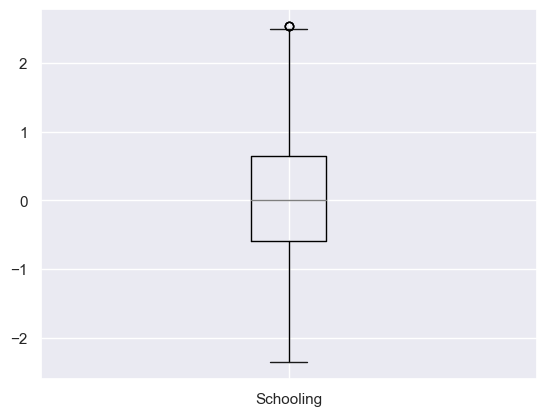

In [87]:
df1 = Xtrain.select_dtypes(exclude=['object'])
for column in df1:
    plt.figure()
    df1.boxplot([column])
plt.show()

Najdeme priznaky pro konvertace na kategoricke priznaky

In [88]:
Xtrain.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1462 entries, 2307 to 2323
Data columns (total 21 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   Country                          1462 non-null   object 
 1   Year                             1462 non-null   int64  
 2   Status                           1462 non-null   object 
 3   Adult Mortality                  1462 non-null   float64
 4   infant deaths                    1462 non-null   float64
 5   Alcohol                          1462 non-null   float64
 6   percentage expenditure           1462 non-null   float64
 7   Hepatitis B                      1462 non-null   float64
 8   Measles                          1462 non-null   float64
 9   BMI                              1462 non-null   float64
 10  under-five deaths                1462 non-null   float64
 11  Polio                            1462 non-null   float64
 12  Total expenditure

In [89]:
for column in Xtrain.columns:
      print(f"{column}: ",len(df[column].unique()))

Country:  183
Year:  16
Status:  2
Adult Mortality:  423
infant deaths:  195
Alcohol:  1056
percentage expenditure:  2185
Hepatitis B:  88
Measles:  909
BMI:  601
under-five deaths:  239
Polio:  74
Total expenditure:  793
Diphtheria:  82
HIV/AIDS:  197
GDP:  2318
Population:  2111
thinness  1-19 years:  195
thinness 5-9 years:  201
Income composition of resources:  614
Schooling:  174


Tady vidime ze pro kategoricky priznak se hodi "Status" a "Country".

In [90]:
cat_cols = Xtrain.select_dtypes(object).columns.tolist()
for col in cat_cols:
      Xtrain[col] = Xtrain[col].astype("category")

cat_cols = Xtrain.select_dtypes("category").columns.tolist()
# BinaryEncoder
encoders = {}
for col in cat_cols:
    encoders[col] = BinaryEncoder()
    encoders[col].fit(Xtrain[col])
    Xtrain = Xtrain.join(pd.DataFrame(encoders[col].transform(Xtrain[col])))
Xtrain

,Country,Year,Status,Adult Mortality,infant deaths,Alcohol,percentage expenditure,Hepatitis B,Measles,BMI,...,Country_0,Country_1,Country_2,Country_3,Country_4,Country_5,Country_6,Country_7,Status_0,Status_1
2307,Sweden,2012,Developed,-0.838005,-1.210536,7.400000,2.039763,-1.679823,3.433987,58.1,...,0,0,0,0,0,0,0,1,0,1
514,Chile,2003,Developing,-2.371286,-0.267290,6.370000,0.859313,-0.304027,0.693147,56.1,...,0,0,0,0,0,0,1,0,1,0
1236,Kazakhstan,2009,Developing,0.717082,0.390622,6.640000,0.986287,1.143739,0.000000,48.5,...,0,0,0,0,0,0,1,1,1,0
1659,Myanmar,2000,Developing,0.765626,1.420992,0.350000,-1.027815,-0.304027,6.740519,13.6,...,0,0,0,0,0,1,0,0,1,0
2665,Viet Nam,2004,Developing,0.009759,1.066840,2.860000,-1.459456,0.694571,5.384495,1.9,...,0,0,0,0,0,1,0,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1006,Guinea-Bissau,2001,Developing,-1.255737,0.213226,2.550000,-1.246082,-0.304027,4.844187,17.9,...,1,0,1,1,0,0,1,0,1,0
130,Austria,2013,Developed,-0.689290,-1.210536,11.820000,0.150458,0.781310,0.000000,56.6,...,1,0,0,0,1,1,0,0,0,1
2204,South Africa,2015,Developing,1.230916,1.217188,4.754504,-1.459456,-0.676469,2.890372,51.1,...,0,0,0,1,1,0,0,1,1,0
3,Afghanistan,2012,Developing,0.933989,1.401313,0.010000,0.096065,-1.107833,6.908755,17.6,...,1,0,1,0,1,1,1,0,1,0


Muzeme zahodit priznaky "Status","Country","infant deaths"(protoze ma corelaci = 0.99 z "under-five deaths") a "thinness 5-9 years" (taky ma vysokou korelace 0.94 z "thinness 1-19 years"):

In [91]:
Xtrain.drop(columns=['Status','Country','infant deaths','thinness 5-9 years'],inplace=True)

In [92]:
Xtrain

,Year,Adult Mortality,Alcohol,percentage expenditure,Hepatitis B,Measles,BMI,under-five deaths,Polio,Total expenditure,...,Country_0,Country_1,Country_2,Country_3,Country_4,Country_5,Country_6,Country_7,Status_0,Status_1
2307,2012,-0.838005,7.400000,2.039763,-1.679823,3.433987,58.1,-1.231957,0.880790,2.181800,...,0,0,0,0,0,0,0,1,0,1
514,2003,-2.371286,6.370000,0.859313,-0.304027,0.693147,56.1,-0.354229,0.702560,0.633750,...,0,0,0,0,0,0,1,0,1,0
1236,2009,0.717082,6.640000,0.986287,1.143739,0.000000,48.5,0.341515,0.972425,-0.730960,...,0,0,0,0,0,0,1,1,1,0
1659,2000,0.765626,0.350000,-1.027815,-0.304027,6.740519,13.6,1.406363,0.054713,-1.965514,...,0,0,0,0,0,1,0,0,1,0
2665,2004,0.009759,2.860000,-1.459456,0.694571,5.384495,1.9,1.028930,0.702560,0.057467,...,0,0,0,0,0,1,0,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1006,2001,-1.255737,2.550000,-1.246082,-0.304027,4.844187,17.9,0.400131,-1.626115,-0.155015,...,1,0,1,1,0,0,1,0,1,0
130,2013,-0.689290,11.820000,0.150458,0.781310,0.000000,56.6,-1.231957,0.615935,1.970052,...,1,0,0,0,1,1,0,0,0,1
2204,2015,1.230916,4.754504,-1.459456,-0.676469,2.890372,51.1,1.173297,-0.791081,0.078057,...,0,0,0,1,1,0,0,1,1,0
3,2012,0.933989,0.010000,0.096065,-1.107833,6.908755,17.6,1.381947,-1.196118,1.073440,...,1,0,1,0,1,1,1,0,1,0


## Validacni a testovaci

Ted' trasformujeme validacni a testovaci datasety s použitím informací o kódováni atd. z předchozího bodu:

In [93]:
for col in cols_1000:
      Xval[col] = Xval[col].apply(limit_for_1000)
for col in cols_100:
      Xval[col] = Xval[col].apply(limit_for_100)

<AxesSubplot:xlabel='Count', ylabel='index'>

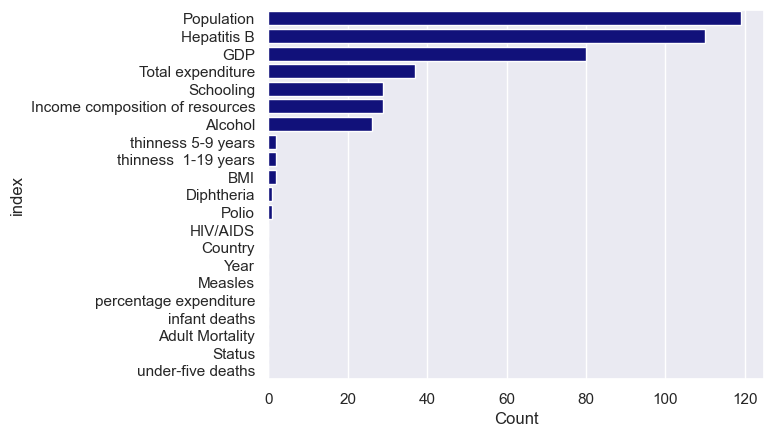

In [94]:
nans = Xval.isnull().sum().reset_index(name="Count").sort_values(by="Count",ascending=False)
sns.barplot(data=nans,y="index",x="Count",color='darkblue')

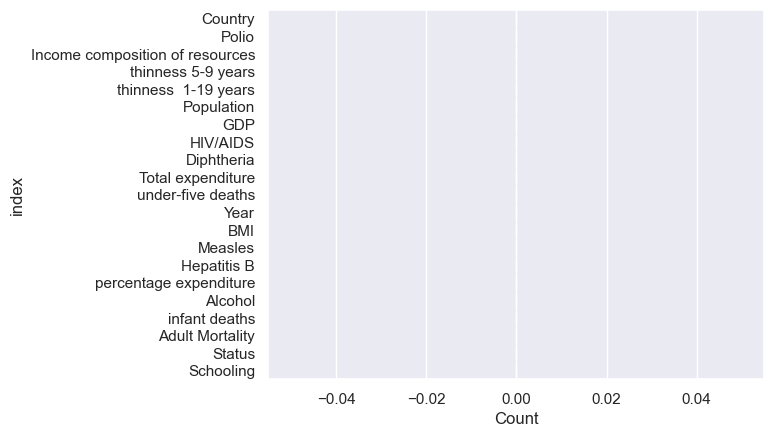

,Year,Adult Mortality,Alcohol,percentage expenditure,Hepatitis B,Measles,BMI,under-five deaths,Polio,Total expenditure,...,Country_0,Country_1,Country_2,Country_3,Country_4,Country_5,Country_6,Country_7,Status_0,Status_1
1514,2007,-0.728341,7.45,1.447715,-0.230529,1.098612,66.1,-1.231957,-0.734533,1.015310,...,1,0,0,1,0,0,0,1,0,1
1485,2004,-1.640829,1.60,0.877437,0.959409,3.637586,17.3,-1.231957,0.702560,0.053286,...,0,0,1,1,0,1,1,0,1,0
720,2003,-1.477884,6.32,0.592893,-0.429756,0.000000,46.1,0.341515,-1.284776,-0.099076,...,1,0,1,1,0,1,0,0,1,0
737,2002,0.180682,3.88,0.422686,-0.676469,0.000000,45.1,0.452043,0.054713,-0.501927,...,0,0,0,1,0,0,1,1,1,0
1700,2001,-0.519385,9.95,1.516048,-0.304027,0.000000,52.6,-0.654692,0.790840,0.804518,...,0,1,1,1,1,1,0,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1471,2002,-1.702760,0.49,0.477808,0.781310,6.013715,27.9,-0.010586,0.530951,-1.091194,...,1,0,1,0,0,1,1,1,1,0
452,2007,1.548568,5.44,-0.714131,-0.230529,4.615121,24.4,1.366984,-0.431025,-0.438147,...,1,0,0,1,1,1,1,1,1,0
512,2005,-0.397665,7.57,1.051876,-0.304027,0.000000,57.4,-0.354229,0.365850,0.379633,...,0,0,0,0,0,0,1,0,1,0
1541,2012,0.157138,0.01,1.035123,1.050789,0.000000,31.8,-1.231957,0.880790,-0.438147,...,0,0,0,0,0,1,1,1,1,0


In [95]:

nans = nans.iloc[np.where(nans['Count'].array > 0)]['index'].array
for col in nans:
      Xval[col].fillna(mean_by_columns[col],inplace=True)

nans = Xval.isnull().sum().reset_index(name="Count").sort_values(by="Count",ascending=False)
sns.barplot(data=nans,y="index",x="Count",color='darkblue')
plt.show()

for col in power_cols:
      Xval[col] = power_tr[col].transform(Xval[col].array.reshape(-1, 1))

for col in log_cols:
      Xval[col] = log_tr[col].transform(Xval[col].array.reshape(-1, 1))




cat_cols = Xval.select_dtypes(object).columns.tolist()
for col in cat_cols:
      Xval[col] = Xval[col].astype("category")

cat_cols = Xval.select_dtypes("category").columns.tolist()

# BinaryEncoder
for col in cat_cols:
    Xval = Xval.join(pd.DataFrame(encoders[col].transform(Xval[col])))

Xval.drop(columns=['Status','Country','infant deaths','thinness 5-9 years'],inplace=True)
Xval

In [96]:
Xval.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 544 entries, 1514 to 669
Data columns (total 27 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   Year                             544 non-null    int64  
 1   Adult Mortality                  544 non-null    float64
 2   Alcohol                          544 non-null    float64
 3   percentage expenditure           544 non-null    float64
 4   Hepatitis B                      544 non-null    float64
 5   Measles                          544 non-null    float64
 6   BMI                              544 non-null    float64
 7   under-five deaths                544 non-null    float64
 8   Polio                            544 non-null    float64
 9   Total expenditure                544 non-null    float64
 10  Diphtheria                       544 non-null    float64
 11  HIV/AIDS                         544 non-null    float64
 12  GDP                

In [97]:
for col in cols_1000:
      Xtest[col] = Xtest[col].apply(limit_for_1000)
for col in cols_100:
      Xtest[col] = Xtest[col].apply(limit_for_100)

<AxesSubplot:xlabel='Count', ylabel='index'>

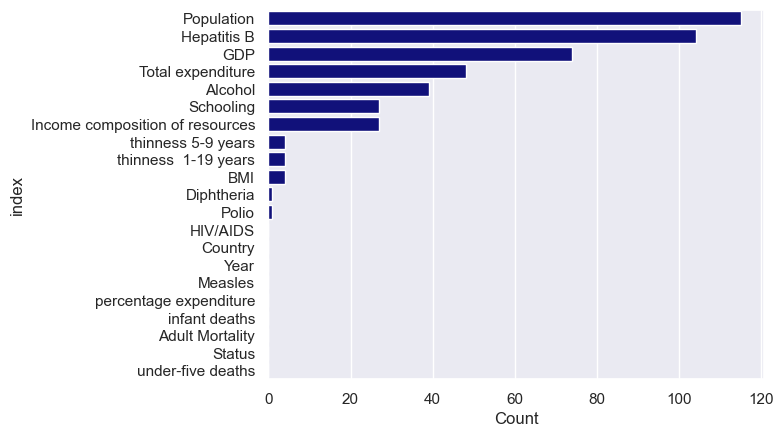

In [98]:
nans = Xtest.isnull().sum().reset_index(name="Count").sort_values(by="Count",ascending=False)
sns.barplot(data=nans,y="index",x="Count",color='darkblue')

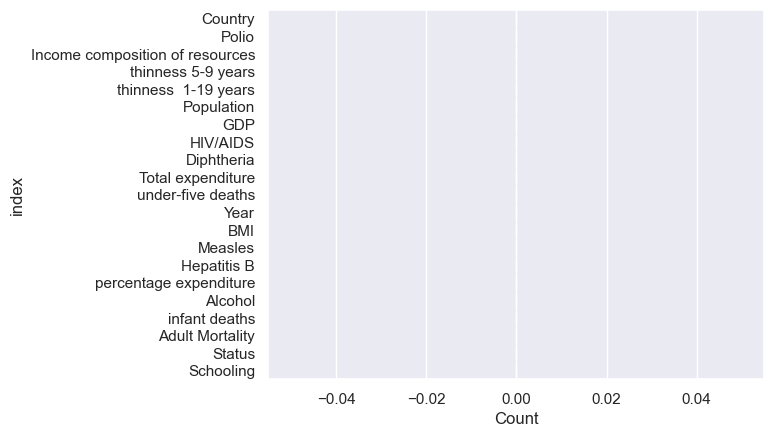

,Year,Adult Mortality,Alcohol,percentage expenditure,Hepatitis B,Measles,BMI,under-five deaths,Polio,Total expenditure,...,Country_0,Country_1,Country_2,Country_3,Country_4,Country_5,Country_6,Country_7,Status_0,Status_1
404,2007,1.756671,2.580000,-1.459456,-0.616783,1.791759,23.2,1.359197,-0.791081,0.242885,...,0,1,0,1,1,1,0,0,1,0
2540,2007,-0.462925,1.690000,1.600235,0.525655,0.000000,55.1,-0.654692,0.530951,-1.535084,...,1,0,1,0,0,1,0,0,1,0
2049,2012,0.451265,0.010000,-0.688683,0.869586,0.000000,28.5,-1.231957,0.702560,1.102342,...,0,0,0,1,0,1,1,0,1,0
1349,2008,-0.345171,1.670000,0.050851,-0.298313,3.218876,62.5,-0.654692,-0.791081,1.138317,...,1,0,1,0,1,0,0,1,1,0
811,2002,0.565213,11.480000,-0.704177,-0.304027,0.000000,54.6,-1.231957,0.530951,-0.402013,...,0,1,0,0,1,0,1,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
459,2000,1.544075,3.910000,-0.856838,-0.304027,6.908755,2.9,1.406363,-1.592640,-0.566421,...,1,0,0,1,1,1,1,1,1,0
1262,2015,0.478598,4.754504,-1.459456,-0.230529,0.000000,77.6,-1.231957,-2.284590,0.078057,...,0,1,0,0,0,0,0,0,1,0
1834,2009,0.165016,5.390000,-0.239504,-0.018789,0.000000,45.6,-0.156144,-0.431025,1.294678,...,1,0,0,0,0,0,1,0,1,0
2700,2001,2.393626,2.610000,-0.091058,-0.304027,6.908755,17.1,1.282923,-0.091554,0.327672,...,0,1,0,0,1,1,0,0,1,0


In [99]:
nans = nans.iloc[np.where(nans['Count'].array > 0)]['index'].array
for col in nans:
      Xtest[col].fillna(mean_by_columns[col],inplace=True)

nans = Xtest.isnull().sum().reset_index(name="Count").sort_values(by="Count",ascending=False)
sns.barplot(data=nans,y="index",x="Count",color='darkblue')
plt.show()

for col in power_cols:
      Xtest[col] = power_tr[col].transform(Xtest[col].array.reshape(-1, 1))

for col in log_cols:
      Xtest[col] = log_tr[col].transform(Xtest[col].array.reshape(-1, 1))




cat_cols = Xtest.select_dtypes(object).columns.tolist()
for col in cat_cols:
      Xtest[col] = Xtest[col].astype("category")

cat_cols = Xtest.select_dtypes("category").columns.tolist()

# BinaryEncoder
for col in cat_cols:
    Xtest = Xtest.join(pd.DataFrame(encoders[col].transform(Xtest[col])))

Xtest.drop(columns=['Status','Country','infant deaths','thinness 5-9 years'],inplace=True)
Xtest

# Aplikace modelů

## Nahodny Les

Náhodný les je metoda ensemble, která kombinuje více rozhodovacích stromů s cílem zlepšit přesnost predikce a kontrolovat nadměrné přizpůsobení.

Vhodnost a silné stránky:
* Nelinearita a komplexní vztahy: Náhodné lesy jsou obecně schopny zachytit nelineární a komplexní vztahy v datech.

* Odolnost vůči nadměrnému přizpůsobení: Náhodné lesy jsou známé svou odolností vůči nadměrnému přizpůsobení. Díky agregaci předpovědí z více stromů má model tendenci se dobře zobecňovat na neznámá data, což je zásadní pro předpovědi očekávané délky života v různých zemích.

* Důležitost priznaků: Model umožňuje analyzovat důležitost rysů, což pomáhá určit, které faktory přispívají k rozdílům v délce života významněji.

* Flexibilita a všestrannost: Model Random Forest je všestranný a dokáže pracovat s různými typy dat a rozděleními rysů. Tato flexibilita je výhodná při práci s různými socioekonomickými a zdravotními proměnnými.

Slabé stránky a úvahy:

* Ladění hyperparametrů: Výkonnost modelu může být citlivá na hyperparametry, jako je počet stromů (n_estimátorů), maximální hloubka každého stromu (max_depth) a další.

* Kvalita a reprezentativnost dat: Účinnost modelu závisí na kvalitě a reprezentativnosti vstupních dat. Problémy, jako jsou chybějící data, odlehlé hodnoty nebo neobjektivní výběr vzorků, mohou ovlivnit přesnost a zobecnitelnost modelu.

Ujistěme se, že tento model není citlivý na škálování dat. 

In [100]:
options = ["No scale","StandartScaler","MinMaxScaler"]

param_grid = {
          'n_estimators': range(3, 15),
          'max_depth': range(1, 5),
          'max_samples': range(10, 200, 10)
}

param_comb = ParameterGrid(param_grid)      

global_err = np.inf
global_best_params = {}
global_best_option_forest = "No scale"

for option in options:
     Xtrain_scaled = Xtrain.copy()
     Xval_scaled = Xval.copy()
     
     if option != "No scale":
         if option == "StandartScaler":
              X_scaler = StandardScaler()
              y_scaler = StandardScaler()
         else:
              X_scaler = MinMaxScaler()
              y_scaler = MinMaxScaler()
         
         Xtrain_scaled = pd.DataFrame(X_scaler.fit_transform(Xtrain_scaled.values), index=Xtrain_scaled.index, columns=Xtrain_scaled.columns)
         Xval_scaled = pd.DataFrame(X_scaler.fit_transform(Xval_scaled.values), index=Xval_scaled.index, columns=Xval_scaled.columns)

     val_metric = []
     for params in param_comb:
         dt = CustomRandomForest(**params, random_state = random_seed)
         dt.fit(Xtrain_scaled, ytrain)
         val_metric.append(metrics.mean_squared_error(yval, dt.predict(Xval_scaled), squared = False))
     
     best_params = param_comb[np.argmin(val_metric)]

     if global_err > min(val_metric):
          global_err = min(val_metric)
          global_best_params = best_params
          global_best_option_forest = option
     
     print(f"{option}:\nWe found the best params {best_params} with validation RMSE {min(val_metric):.6f}.\n")

No scale:
We found the best params {'n_estimators': 11, 'max_samples': 190, 'max_depth': 4} with validation RMSE 3.018162.

StandartScaler:
We found the best params {'n_estimators': 14, 'max_samples': 140, 'max_depth': 4} with validation RMSE 3.182525.

MinMaxScaler:
We found the best params {'n_estimators': 9, 'max_samples': 110, 'max_depth': 4} with validation RMSE 2.987542.



Jak vidíme, výsledky se příliš neliší.

## Hřebenova regrese

Hřebenová regrese je lineární regresní technika, která k funkci OLS (ordinary least squares) přidává trestný člen. Účelem tohoto sankčního členu je zabránit nadměrnému přizpůsobení a regulovat model tím, že odrazuje od velkých hodnot koeficientů.

Cílem Hřebenové regrese je najít koeficienty, které dobře odpovídají datům, a zároveň je udržet co nejmenší. Síla regularizace se řídí parametrem, který se nazývá síla regularizace neboli alfa.

Vhodnost:

* Multikolinearita: Hřebenové regrese se dobře vypořádává s multikolinearitou přidáním regularizačního členu, což pomáhá stabilizovat model a zlepšit jeho zobecnění na nová data.

* Prevence nadměrného přizpůsobení: Hřebenová regrese je užitečná v případě, že existuje riziko nadměrného přizpůsobení. Regularizační člen pomáhá zabránit tomu, aby se model přizpůsobil šumu v datech, a poskytuje hladší řešení.

* Vyrovnání zkreslení a rozptylu: Hřebenová regrese zajišťuje rovnováhu mezi  "bias" a "variance".

Slabé stránky:

* Předpoklad linearity: Hřebenová regrese předpokládá lineární vztah mezi proměnnými prediktoru a proměnnou odpovědi. Pokud je vztah vysoce nelineární, Ridgeova regrese jej nemusí účinně zachytit.

* Volba regularizačního parametru: Výkonnost Hřebenove regrese závisí na správné volbě regularizačního parametru ($\alpha$). Pokud je volba parametru $\alpha$ není optimální, může buď příliš penalizovat koeficienty, nebo na ně mít jen malý vliv.

Tento model by měl ze StandartScaleru těžit více:

In [101]:
def ridgemodel_eval(alpha):
     clf = Ridge(alpha=alpha)
     clf.fit(Xtrain_scaled, ytrain)
     return metrics.mean_squared_error(yval, clf.predict(Xval_scaled), squared = False)

global_opt_err = np.inf
global_opt_alpha = np.inf
global_best_option_ridge = "No scale"

options = ["No scale","StandartScaler","MinMaxScaler"]

for option in options:
     Xtrain_scaled = Xtrain.copy()
     Xval_scaled = Xval.copy()
     
     if option != "No scale":
         if option == "StandartScaler":
              X_scaler = StandardScaler()
              y_scaler = StandardScaler()
         else:
              X_scaler = MinMaxScaler()
              y_scaler = MinMaxScaler()
         
         Xtrain_scaled = pd.DataFrame(X_scaler.fit_transform(Xtrain_scaled.values), index=Xtrain_scaled.index, columns=Xtrain_scaled.columns)
         Xval_scaled = pd.DataFrame(X_scaler.fit_transform(Xval_scaled.values), index=Xval_scaled.index, columns=Xval_scaled.columns)

     opt_alpha = optimize.minimize_scalar(ridgemodel_eval, options = {'maxiter': 30}, method = 'bounded', bounds=(0.1, 400))
     clf_opt_ridge = Ridge(alpha = opt_alpha.x)
     clf_opt_ridge.fit(Xtrain_scaled, ytrain)
     RMSE_val_opt_ridge = metrics.mean_squared_error(yval, clf_opt_ridge.predict(Xval_scaled), squared = False)

     if (global_opt_err > RMSE_val_opt_ridge):
          global_opt_err = RMSE_val_opt_ridge
          global_opt_alpha = opt_alpha['x']
          global_best_option_ridge = option

     print(f"{option}:\nWe found the optimal alpha {opt_alpha['x']:.6f} with validation RMSE {RMSE_val_opt_ridge:.6f}.\n")

No scale:
We found the optimal alpha 71.246090 with validation RMSE 3.891784.

StandartScaler:
We found the optimal alpha 48.944630 with validation RMSE 3.911095.

MinMaxScaler:
We found the optimal alpha 8.746722 with validation RMSE 3.920355.



Tady je zajimave, ze model mela mensi chybu, kdyz jsme nepouzili scaler na datech

## AdaBoost

AdaBoost, zkratka pro Adaptive Boosting, je metoda ensemble, která kombinuje předpovědi více slabých učících se subjektů a vytváří tak silný učící se subjekt. Jednou z klíčových vlastností modelu AdaBoost je, že se v průběhu iterací přizpůsobuje a průběžně klade větší důraz na případy, které jsou spatne předpovědeny.

**Použitelnost:**

* **Správa nelinearity:** AdaBoost je schopen zachytit nelineární vztahy kombinací více slabých učících se.

* **Přizpůsobivost:** Schopnost AdaBoostu přizpůsobit se a dát větší váhu nesprávně klasifikovaným případům by mohla být přínosná pro řešení odlehlých hodnot nebo případů s neobvyklými hodnotami očekávané délky života.

* **Skupinové učení:** Díky skupinové povaze AdaBoost, která kombinuje více slabých učících se, je robustní a méně náchylná k nadměrnému přizpůsobení.

* **Zpracování chybějících údajů:** AdaBoost dokáže efektivně zpracovávat chybějící údaje, což je důležité v souborech reálných dat, kde nemusí být pro každý případ k dispozici všechny informace.

**Slabé stránky:**

* **Citlivost na zašuměná data:** AdaBoost může být citlivý na zašuměná data a odlehlé hodnoty. Přizpůsobuje se sice chybně klasifikovaným instancím, ale může také přikládat nepatřičnou důležitost odlehlým hodnotám, což může ovlivnit výkonnost modelu.

* **Výpočetní náročnost:** Postupné trénování více slabých učících se může být výpočetně náročné, zejména pokud je soubor dat velký. To může být nevýhodou v situacích, kdy jsou výpočetní zdroje omezené.


In [102]:
options = ["No scale","StandartScaler","MinMaxScaler"]

param_grid = {
          'n_estimators': range(10, 100, 10),
          'max_depth': range(1, 7)
}

param_comb = ParameterGrid(param_grid)      

global_err_ada = np.inf
global_best_params_ada = {}
global_best_option_ada = "No scale"

for option in options:
     Xtrain_scaled = Xtrain.copy()
     Xval_scaled = Xval.copy()
     
     if option != "No scale":
         if option == "StandartScaler":
              X_scaler = StandardScaler()
              y_scaler = StandardScaler()
         else:
              X_scaler = MinMaxScaler()
              y_scaler = MinMaxScaler()
         
         Xtrain_scaled = pd.DataFrame(X_scaler.fit_transform(Xtrain_scaled.values), index=Xtrain_scaled.index, columns=Xtrain_scaled.columns)
         Xval_scaled = pd.DataFrame(X_scaler.fit_transform(Xval_scaled.values), index=Xval_scaled.index, columns=Xval_scaled.columns)

     val_metric = []
     for params in param_comb:
          dt_depth = params.pop("max_depth")
          params["base_estimator"] = DecisionTreeRegressor(max_depth = dt_depth,random_state=random_seed)
          dt = AdaBoostRegressor(**params, random_state = random_seed).fit(Xtrain_scaled, ytrain)
          val_metric.append(metrics.mean_squared_error(yval, dt.predict(Xval_scaled), squared = False))

     best_params = param_comb[np.argmin(val_metric)]

     if global_err_ada > min(val_metric):
          global_err_ada = min(val_metric)
          global_best_params_ada = best_params
          global_best_option_ada = option
     
     print(f"{option}:\nWe found the best params {best_params} with validation RMSE {min(val_metric):.6f}.\n")

No scale:
We found the best params {'n_estimators': 90, 'max_depth': 6} with validation RMSE 2.269439.

StandartScaler:
We found the best params {'n_estimators': 80, 'max_depth': 6} with validation RMSE 2.576199.

MinMaxScaler:
We found the best params {'n_estimators': 60, 'max_depth': 6} with validation RMSE 2.239731.



# Metriky pro nejlepsi hyperparametry

In [103]:
Xtrain_scaled = Xtrain.copy()
Xval_scaled = Xval.copy()

if global_best_option_forest != "No scale":
    if option == "StandartScaler":
         X_scaler = StandardScaler()
    else:
         X_scaler = MinMaxScaler()
    
    Xtrain_scaled = pd.DataFrame(X_scaler.fit_transform(Xtrain_scaled.values), index=Xtrain_scaled.index, columns=Xtrain_scaled.columns)
    Xval_scaled = pd.DataFrame(X_scaler.fit_transform(Xval_scaled.values), index=Xval_scaled.index, columns=Xval_scaled.columns)


best_random_forest = CustomRandomForest(**global_best_params, random_state = random_seed)
best_random_forest.fit(Xtrain_scaled, ytrain)
RMSE_f = metrics.mean_squared_error(yval, best_random_forest.predict(Xval_scaled), squared = False)
MAE_f = metrics.mean_absolute_error(yval, best_random_forest.predict(Xval_scaled))
print(f"Random Forest with best parameters\nValidation RMSE {RMSE_f:.6f}\nValidation MAE  {MAE_f:.6f}.\n")


Xtrain_scaled = Xtrain.copy()
Xval_scaled = Xval.copy()

if global_best_option_ridge != "No scale":
    if option == "StandartScaler":
         X_scaler = StandardScaler()
    else:
         X_scaler = MinMaxScaler()
    
    Xtrain_scaled = pd.DataFrame(X_scaler.fit_transform(Xtrain_scaled.values), index=Xtrain_scaled.index, columns=Xtrain_scaled.columns)
    Xval_scaled = pd.DataFrame(X_scaler.fit_transform(Xval_scaled.values), index=Xval_scaled.index, columns=Xval_scaled.columns)


best_ridge = Ridge(alpha=global_opt_alpha).fit(Xtrain_scaled, ytrain)
RMSE_r = metrics.mean_squared_error(yval, best_ridge.predict(Xval_scaled), squared = False)
MAE_r = metrics.mean_absolute_error(yval, best_ridge.predict(Xval_scaled))
print(f"Ridge with best parameters\nValidation RMSE {RMSE_r:.6f}\nValidation MAE  {MAE_r:.6f}.\n")


Xtrain_scaled = Xtrain.copy()
Xval_scaled = Xval.copy()

if global_best_option_ada != "No scale":
    if option == "StandartScaler":
         X_scaler = StandardScaler()
    else:
         X_scaler = MinMaxScaler()
    
    Xtrain_scaled = pd.DataFrame(X_scaler.fit_transform(Xtrain_scaled.values), index=Xtrain_scaled.index, columns=Xtrain_scaled.columns)
    Xval_scaled = pd.DataFrame(X_scaler.fit_transform(Xval_scaled.values), index=Xval_scaled.index, columns=Xval_scaled.columns)


dt_depth = global_best_params_ada.pop("max_depth")
global_best_params_ada["base_estimator"] = DecisionTreeRegressor(max_depth = dt_depth,random_state=random_seed)
best_ada = AdaBoostRegressor(**global_best_params_ada, random_state = random_seed).fit(Xtrain_scaled, ytrain)

RMSE_a = metrics.mean_squared_error(yval, best_ada.predict(Xval_scaled), squared = False)
MAE_a = metrics.mean_absolute_error(yval, best_ada.predict(Xval_scaled))
print(f"AdaBoost with best parameters\nValidation RMSE {RMSE_a:.6f}\nValidation MAE  {MAE_a:.6f}.\n")

Random Forest with best parameters
Validation RMSE 3.310091
Validation MAE  2.455087.

Ridge with best parameters
Validation RMSE 3.891784
Validation MAE  2.929111.

AdaBoost with best parameters
Validation RMSE 2.239731
Validation MAE  1.627579.



Vidime, ze nejlepsi model je AdaBoost. Natrenujeme ho na testovacich a validacnich datech:

In [104]:
Xtrain_scaled = Xtrain.copy()
Xval_scaled = Xval.copy()

if global_best_option_ada != "No scale":
    if option == "StandartScaler":
         X_scaler = StandardScaler()
    else:
         X_scaler = MinMaxScaler()
    
    Xtrain_scaled = pd.DataFrame(X_scaler.fit_transform(Xtrain_scaled.values), index=Xtrain_scaled.index, columns=Xtrain_scaled.columns)
    Xval_scaled = pd.DataFrame(X_scaler.fit_transform(Xval_scaled.values), index=Xval_scaled.index, columns=Xval_scaled.columns)

Xtrainval_scaled = pd.concat([Xtrain_scaled,Xval_scaled],axis=0)
ytrainval = pd.concat([ytrain,yval],axis=0)

best_model = AdaBoostRegressor(**global_best_params_ada, random_state = random_seed).fit(Xtrainval_scaled, ytrainval)


# RMSE na nových datech

Uvidíme, co nám zobrazí metriky na nových, neznámých datech:

In [105]:
Xtest_scaled = Xtest.copy()

if global_best_option_ada != "No scale":
    if option == "StandartScaler":
         X_scaler = StandardScaler()
    else:
         X_scaler = MinMaxScaler()
    
    Xtest_scaled = pd.DataFrame(X_scaler.fit_transform(Xtest_scaled.values), index=Xtest_scaled.index, columns=Xtest_scaled.columns)


RMSE = metrics.mean_squared_error(ytest, best_model.predict(Xtest_scaled), squared = False)
print(f"Model with best parameters\nTest RMSE {RMSE:.6f}.")

Model with best parameters
Test RMSE 2.221941.


Tento výsledek znamená, že chyba v předpovědi očekávané délky života může být přibližně plus (nebo minus) 2 roky. 